Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

## Colab

In [1]:
PATH = './drive/MyDrive/1_SP_Ham_func/'

# Mount your google drive 
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Imports

In [2]:
!pip install torchdiffeq

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torchdiffeq import odeint_adjoint as odeint_adjoint 
# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time

import json

In [4]:
# set device to GPU if available otherwise use CPU
def set_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        # if there is a GPU
        print (f'Available device : {torch.cuda.get_device_name(0)}') 
    else :
        print(device)
    return device

device = set_device()

cpu


## Data Generation

Structure inspired from https://github.com/Physics-aware-AI/Symplectic-ODENet/blob/master/experiment-single-force/data.py

### Plot functions for data

In [5]:
def plot_traj_furuta(t_eval, q1, p1, q2, p2, energy=torch.tensor(False),
                     title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian'):
    '''
    This function plots the generalised variables q1, p1, q2, p2, and the energy 
    at the time t_eval at which they were evaluated
    Inputs:
      t_eval (tensor) : vector containing evaluation times of the generalized coordinates
      q1 (tensor) : generalized position q1
      p1 (tensor) : generalized momentum p1
      q2 (tensor) : generalized position q1
      p2 (tensor) : generalized momentum p2
      energy (tensor) : energy evaluated at the provided coordinates, if
          not provided, it will not appear in the plot (default = torch.tensor(False))
    Outputs:
      None
    '''
    # TODO : make this work for two columns
    if torch.any(energy):
        
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(15, 4),constrained_layout=True, sharex=True)# , sharey=True)
        ax5.plot(t_eval, energy, label='energy')

        # ax1.legend()
        ax5.set_title('Energy', fontsize=10)
        ax5.set_xlabel('time (s)')
        ax5.set_ylabel('E')
        ax5.set_ylim((0,torch.max(energy)*1.1))
    else:
       fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4),constrained_layout=True, sharex=True)# , sharey=True)


    ax1.plot(t_eval, q1, label='q1')
    ax2.plot(t_eval, p1, label='p1')
    ax3.plot(t_eval, q2, label='q2')
    ax4.plot(t_eval, p2, label='p2')

    #ax1.legend()
    ax1.set_title('generalized position (q1)', fontsize=10)
    ax1.set_xlabel('time[s]')
    ax1.set_ylabel('q1[rad]')

    #ax2.legend()
    ax2.set_title('generalized momentum (p1)', fontsize=10)
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('p1')

    ax3.set_title('generalized position (q2)', fontsize=10)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('q2[rad]')

    ax4.set_title('generalized momentum (p2)', fontsize=10)
    ax4.set_xlabel('time [s]')
    ax4.set_ylabel('p2')
    
    if coord_type == 'newtonian':
        ax2.set_title(r'$\dot{q1}[rad/s]$', fontsize=10)
        ax2.set_ylabel(r'$\dot{q1}[rad/s]$')
        ax4.set_title(r'$\dot{q2}[rad/s]$', fontsize=10)
        ax4.set_ylabel(r'$\dot{q2}[rad/s]$')

    fig.suptitle(title, fontsize=12)
    plt.show()
    return

### Dynamics

In [6]:
# g = 9.81
# Jr = 5.72*1e-5
# Lr = 0.085
# Mp = 0.024
# Lp = 0.129
# Jp = (1/12)*Mp*Lp**2

# # function constants
# C1 = Jr + Mp*Lr**2
# C2 = (1/4)*Mp*Lp**2
# C3 = (-1/2)*Mp*Lp*Lr
# C4 = Jp+C2
# C5 = (1/2)*Mp*g*Lp

In [7]:
def furuta_H(q1, p1, q2, p2, g, Jr, Lr, Mp, Lp):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum 
    Inputs : 
      - q1,p1,q2,p2 (tensors) : Generalized coordinates 
    Outputs : 
      - H (tensor) : Hamiltonian function 
    Credits : 
      - Equations & constants are from Jonas's report
    ''' 
    # g = 9.81,
    # Jr = 5.72*1e-5,
    # Lr = 0.085,
    # Mp = 0.024,
    # Lp = 0.129
    # g = 9.81

    # Jr = 5.72*1e-5
    # Lr = 0.085
    # Mp = 0.024
    # Lp = 0.129
    # Jp = (1/12)*Mp*Lp**2

    # system constants
    Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp

    # hamiltonian function
    H = p1**2 * (C1+C2*torch.sin(q1)**2 )+ C4*p2**2-2*p1*p2*C3*torch.cos(q1)
    H = (1/2) * (H)/(C1*C4+C4*C2*torch.sin(q1)**2 - (C3**2) * (torch.cos(q1)**2)) 
    H = H + C5*(torch.cos(q1)+1)

    return H
    
def hamiltonian_fn_furuta(coords, g, Jr, Lr, Mp, Lp):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum, wraps furuta_H so that it is 
      the right format for ODEint

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2

    Outputs :
      - H (tensor) : Scalar Hamiltonian function

    Credits : 
      This function takes the same structure as the one in the SymODEN repository
    '''
    q1,p1,q2,p2 = torch.split(coords,1)

    H = furuta_H(q1, p1, q2, p2, g, Jr, Lr, Mp, Lp)
    return H

def coord_derivatives_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func, utype, gtype):
    '''
    Description:
        Returns the derivatives of the generalized coordinates

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2
      - C_q1 (float) : coefficient of friction related to p1 ( and q1)
      - C_q2 (float) : coefficient of friction related to p2 ( and q2)

    Outputs :
      - dq1dt, dp1dt, dq2dt, dp2dt (tensors) : Derivatives w.r.t coords
    '''
    if coords.requires_grad is not True:
        coords.requires_grad=True

    # Hamiltonian function
    H = hamiltonian_fn_furuta(coords, g, Jr, Lr, Mp, Lp)

    # gradient of the hamiltornian function wrt the generalized coordinates
    dcoords = torch.autograd.grad(H, coords, create_graph=True) # !! might need to add H.sum() if batches used here later

    dHdq1, dHdp1, dHdq2, dHdp2 = torch.split(dcoords[0], 1)

    
    if (u_func is not None) & (g_func is not None) :
      u = u_func(t, utype)
      G = g_func(coords, gtype)
    else:
      u = 0
      G = torch.tensor([0.0,0.0,0.0,0.0])

    dq1dt =   dHdp1 + u * G[0]
    dp1dt = - dHdq1 - C_q1*dHdp1 + u * G[2]
    dq2dt =   dHdp2 + u * G[1]
    dp2dt = - dHdq2 - C_q2*dHdp2 + u * G[3]

    return dq1dt, dp1dt, dq2dt, dp2dt
    
def dynamics_fn_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func, utype, gtype):
    '''
    Description:
    Function that returns the gradient (in form of a function) of a Hamiltonian function
    Inputs : 
      - t () : 
      - coords () : generalized coordinates
      - u () : system input
      - C () : dissipation coefficient

    Outputs :£
      - S () : Symplectic gradient

    Credits : 
      - This function has a similar structure as the one in the SymODEN repository
    '''

    dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func, utype, gtype)

    S = torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt))
    return S

### Trajectory

In [8]:
def random_uniform_two_interval(init_method):
    '''
      return x taken from a uniform distribution in one of two intervals 
      [-2,-0.3] or [0.3,2]
    Input : 
      None
    Outputs

    '''
    if init_method == 'random_nozero':
        if torch.tensor([0.5]).bernoulli().bool():
            x = torch.zeros(1).uniform_(0.3, 2)
        else:
            x = torch.zeros(1).uniform_(-2,-0.3)
    elif init_method == 'random_closetozero':
            x = torch.zeros(1).uniform_(-0.3, 0.3)
    elif init_method == 'random_closetopi':
            x = torch.zeros(1).uniform_(torch.pi-0.3, torch.pi+0.3)
    return x

In [9]:
def get_init_state(init_method):
    '''
      Returns initial states q1,p1,q2,p2 for the Furuta pendulum 
      The angular velocities ( /generalized momenmtums) are set to zero
    Inputs : 
      None
    Outputs : 
      y0(tensor) : inital condition
      
    '''
    y0 = torch.zeros(4)

    y0[0] = random_uniform_two_interval(init_method) 
    y0[2] = torch.zeros(1).uniform_(2, 6) # random_uniform_two_interval() 

    y0[1]=0.0 # p1 = 0
    y0[3]=0.0 # p2 = 0
    return y0

In [10]:
def get_trajectory_furuta(utype, gtype, init_method, u_func=None, g_func=None, time_steps=20, y0=None, noise_std=0.0, Ts = 0.005, C_q1=0.0, 
                          C_q2=0.0, g = 9.81, Jr = 5.72*1e-5, Lr = 0.085, Mp = 0.024, Lp = 0.129):   
    '''
    Description:

    Inputs:

    Outputs:
      
    '''

     # sampling time 
    t_eval = torch.linspace(1, time_steps, time_steps) * Ts # evaluated times vector
    t_span = [Ts, time_steps*Ts] # [t_start, t_end]

    # get initial state
    if y0 is None:
        y0 = get_init_state(init_method)

    # solve the differential equation using odeint
    q_p = odeint(func=lambda t, coords: dynamics_fn_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func, utype, gtype), 
                 y0=y0, t=t_eval, method='rk4', options=dict(step_size=Ts)) 

    q1, p1, q2, p2 = torch.chunk(q_p, 4, 1) 

    # add noise 
    q1 = (q1+torch.randn(q1.shape)*noise_std).detach().squeeze()
    p1 = (p1+torch.randn(p1.shape)*noise_std*torch.max(p1)).detach().squeeze()
    q2 = (q2+torch.randn(q2.shape)*noise_std).detach().squeeze()
    p2 = (p2+torch.randn(p2.shape)*noise_std*torch.max(p2)).detach().squeeze()

    # .detach() because the pytorch computational graph is no longer needed
    # only the value is needed
    # .squeeze() to have a desired dimentionality
    # *torch.max(p) otherwise noise is too big compared to the generalized momentum

    return q1, p1, q2, p2, t_eval.detach()

In [11]:
# The "fake" set of furuta parameters to have similar magnitudes in q1 p1 q2 p2
Ts = 0.005
noise_std = 0.0
C_q1 = 0.0
C_q2 = 0.0
g = 9.81
Jr = 1*1e-5
Lr = 0.5
Mp = 5.0
Lp = 0.1

In [12]:
# The set of furuta parameters similar to the real furuta
Ts = 0.005
noise_std = 0.0
C_q1 = 0.0
C_q2 = 0.0
g = 9.81
Jr = 5.72*1e-5
Lr = 0.085
Mp = 0.024
Lp = 0.129

In [13]:
def u_func(t, utype='tanh'):  
  ''' time dependent input '''
  if utype == 'tanh':
      u = (-torch.tanh((t-0.75)*4)+1)/100
  elif utype == 'CHIRP':
      u = chirp_fun(t,T=1.5,f0=1,f1=10)
  elif utype == 'multisine':
      u = multi_sine(t)
  elif utype == 'step':
      u = step_fun(t, t1=0.5)
  u.requires_grad=False
  return u

def g_func(coords, gtype='simple'):
  ''' state dependent input '''
  q1,p1,q2,p2 = torch.split(coords,1)
  if gtype=='simple':
      g = torch.tensor([0,0,1,1]) 
  g.requires_grad=False
  return g

In [14]:
def chirp_fun(t,T=1.5,f0=1,f1=10):
  # https://en.wikipedia.org/wiki/Chirp
  c = (f1-f0)/T
  scale = 1
  return torch.sin(2*torch.pi*(c*t**2/2 + f0*t))*scale

In [15]:
def multi_sine(t):
  scale = 1.0
  f = torch.tensor([2,10,3,4]).unsqueeze(dim=1)
  A = torch.tensor([2,0.5,0.3,0.8]).unsqueeze(dim=1)
  return (A*torch.sin(2*torch.pi*t*f)).sum(dim=0)*scale

In [16]:
def step_fun(t, t1=0.5, value=0.1):
  f = torch.zeros_like(t)
  f[t < t1] = 0
  f[~(t < t1)] = value
  return f

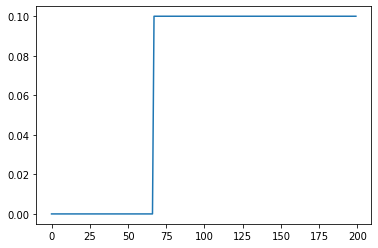

In [17]:
signal = step_fun(t=torch.linspace(0,1.5,200), t1=0.5)
plt.plot(signal)

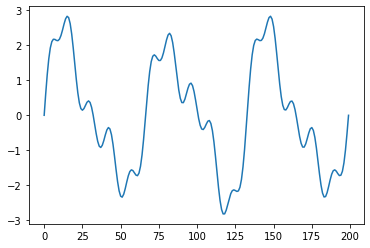

In [18]:
signal = multi_sine(t=torch.linspace(0,1.5,200))
plt.plot(signal)

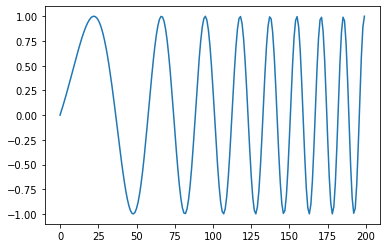

In [19]:
signal = chirp_fun(t=torch.linspace(0,1.5,200),T=1.5,f0=1,f1=10)
plt.plot(signal)

In [20]:
Ts = 0.005
time_steps = 500
t = torch.linspace(1, time_steps, time_steps) * Ts
u = u_func(t, utype='CHIRP')

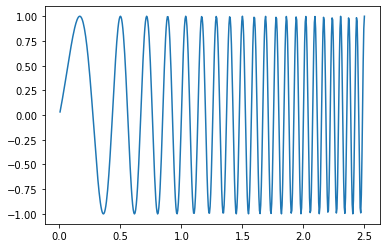

In [21]:
plt.plot(t,u)

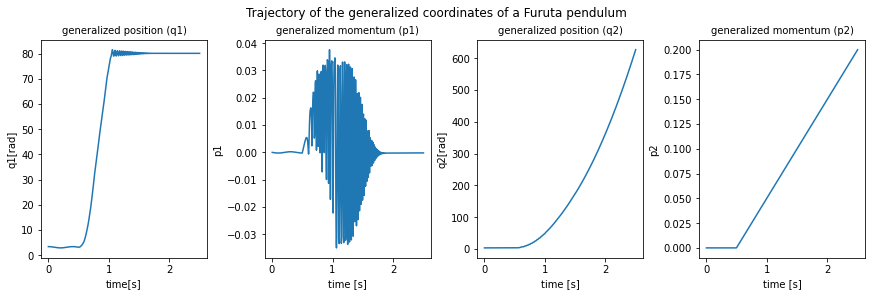

In [22]:
q1, p1, q2, p2, t_eval = get_trajectory_furuta(utype='step', gtype='simple', init_method = 'random_closetopi', u_func=u_func, g_func=g_func, time_steps=500, y0=None, 
                                               noise_std=0.0, Ts=Ts,
                                               C_q1=C_q1, C_q2=C_q2, 
                                               g=g , Jr=Jr, Lr=Lr, 
                                               Mp=Mp , Lp=Lp) #, C_q1=0.000009, C_q2=0.00004)

plot_traj_furuta(t_eval.detach().cpu(),
                      q1.detach().cpu(),
                      p1.detach().cpu(),
                      q2.detach().cpu(),
                      p2.detach().cpu(),
                      title = 'Trajectory of the generalized coordinates of a Furuta pendulum', 
                      coord_type='hamiltonian')

### Energy

In [23]:
def energy_furuta(dq1dt, dq2dt, q1, g, Jr, Lr, Mp, Lp):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # system constants
    Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp
    
    E = (1/2)* dq2dt**2 * (C1+C2*torch.sin(q1)**2)+ dq2dt*dq1dt*C3*torch.cos(q1)
    E = E +(1/2)*dq1dt**2 *C4+C5*torch.cos(q1)+C5

    return E

def get_energy_furuta(time_steps, Ts, u_func, g_func, utype, gtype, q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    energy=[]
    derivatives=[]
    t = torch.linspace(1, time_steps, time_steps) * Ts
    #for t, coords in (t, torch.stack((q1, p1, q2, p2),dim=1)):
    coords = torch.stack((q1, p1, q2, p2),dim=1)
    for i in range(len(t)):

      dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(t[i], coords[i,:],
                                                            C_q1, C_q2, g, Jr, Lr, Mp, Lp,u_func, g_func, utype, gtype)

      q1_n = coords[i,0]
      energy.append(energy_furuta(dq1dt,dq2dt,q1_n, g, Jr, Lr, Mp, Lp))
      derivatives.append(torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt)))
 
    energy = torch.hstack(energy).detach()
    derivatives = torch.vstack(derivatives).detach()
    return energy, derivatives

In [24]:
def get_energy_furuta_newtonian(q1, dq1dt, q2, dq2dt, C_q1, C_q2, g, Jr, Lr, Mp, Lp):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    energy=[]
    derivatives=[]
    for coords in torch.stack((q1, dq1dt, dq2dt),dim=1):

      q1_n = coords[0]
      dq1dt = coords[1]
      dq2dt = coords[2]
      energy.append(energy_furuta(dq1dt,dq2dt,q1_n, g, Jr, Lr, Mp, Lp))

    energy = torch.hstack(energy).detach()
    return energy

### Multiple trajectories

In [25]:
def multiple_trajectories_furuta(utype, gtype, init_method, time_steps, num_trajectories, u_func=None, g_func=None, 
                          y0=torch.tensor([1.0,0.0,1.0,0.0]), Ts = 0.005,
                          noise_std=0.0, C_q1=0.0, C_q2=0.0, g = 9.81, 
                          Jr = 5.72*1e-5, Lr = 0.085, Mp = 0.024, Lp = 0.129, energ_deriv=True):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # the first trajectory
    q1, p1, q2, p2, t_eval = get_trajectory_furuta(utype, gtype, init_method, u_func, g_func, time_steps, y0, noise_std, 
                                                   Ts, C_q1, C_q2, g, Jr, Lr, 
                                                   Mp , Lp)
    energy = []
    derivatives = []
    if energ_deriv:
      energy, derivatives = get_energy_furuta(time_steps, Ts, u_func, g_func, utype, gtype, q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
      derivatives = derivatives.unsqueeze(dim=0)

    for _ in range(num_trajectories-1):
        # the trajectories 2 to num_trajectories
        q1_n, p1_n, q2_n, p2_n, t_eval_n = get_trajectory_furuta(utype, gtype, init_method, u_func, g_func, time_steps, 
                                                                 y0, noise_std, 
                                                                Ts, C_q1, C_q2, g, Jr, Lr, 
                                                                Mp , Lp)
        energy_n, derivatives_n = get_energy_furuta(time_steps, Ts, u_func, g_func, utype, gtype, q1_n, p1_n, q2_n, p2_n, C_q1, C_q2, g, Jr, Lr, Mp, Lp)

        q1 = torch.vstack((q1, q1_n))
        p1 = torch.vstack((p1, p1_n))
        q2 = torch.vstack((q2, q2_n))
        p2 = torch.vstack((p2, p2_n))

        if energ_deriv:
            energy = torch.vstack((energy, energy_n))
            derivatives  = torch.vstack((derivatives, derivatives_n.unsqueeze(dim=0)))
        # t_eval = torch.vstack((t_eval, t_eval_n))
      
    if num_trajectories == 1 :
        # so that the vectors will have the correct dimensions if only 1
        # trajectory is requested
        q1 = q1.unsqueeze(dim=0)
        p1 = p1.unsqueeze(dim=0)
        q2 = q2.unsqueeze(dim=0)
        p2 = p2.unsqueeze(dim=0)
        if energ_deriv:
          energy = energy.unsqueeze(dim=0)
          derivatives = derivatives

        # t_eval = t_eval.unsqueeze(dim=0)

    return q1, p1, q2, p2, energy, derivatives, t_eval

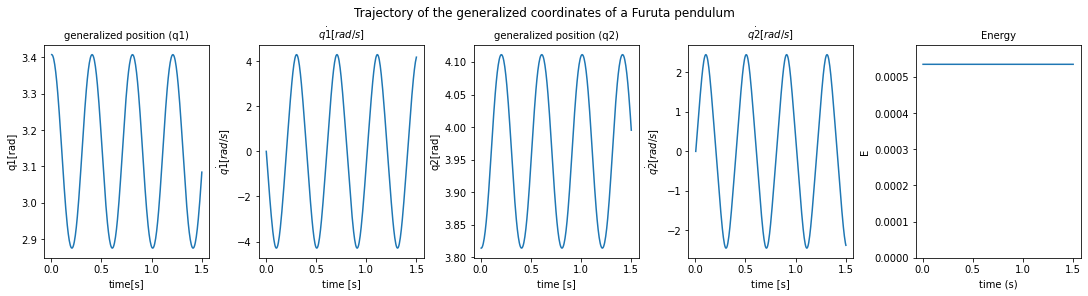

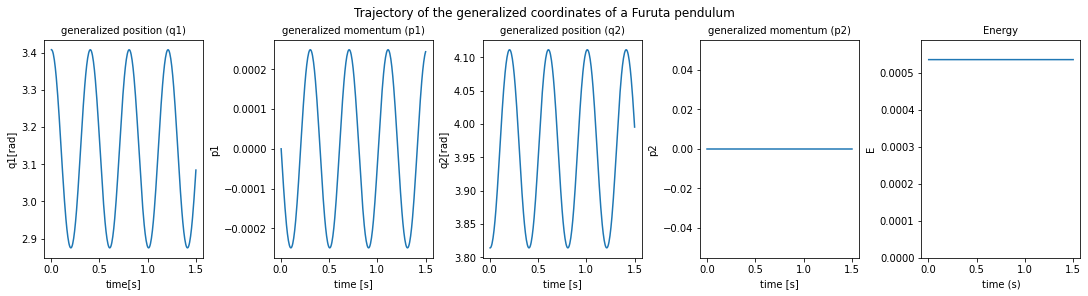

In [26]:
time_steps = 300
q1, p1, q2, p2, t_eval = get_trajectory_furuta(utype='step', gtype='simple', init_method = 'random_closetopi', u_func=None, g_func=None, time_steps=time_steps, y0=None, 
                                               noise_std=0.0, Ts = Ts,
                                               C_q1 = C_q1, C_q2 = C_q2, 
                                               g = g , Jr = Jr, Lr = Lr, 
                                               Mp = Mp , Lp = Lp) #, C_q1=0.000009, C_q2=0.00004)

energy, derivatives = get_energy_furuta(time_steps, Ts, None, None, 'step', 'simple', q1, p1, q2, p2, C_q1 = C_q1, C_q2 = C_q2, 
                                               g = g , Jr = Jr, Lr = Lr, 
                                               Mp = Mp , Lp = Lp)

plot_traj_furuta(t_eval, q1, derivatives[:,0], q2, derivatives[:,2], energy,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='newtonian')

plot_traj_furuta(t_eval, q1, p1, q2, p2, energy,
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='hamiltonian')

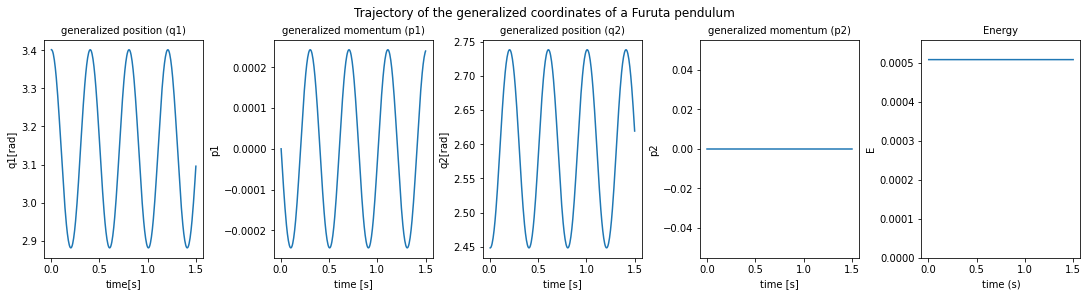

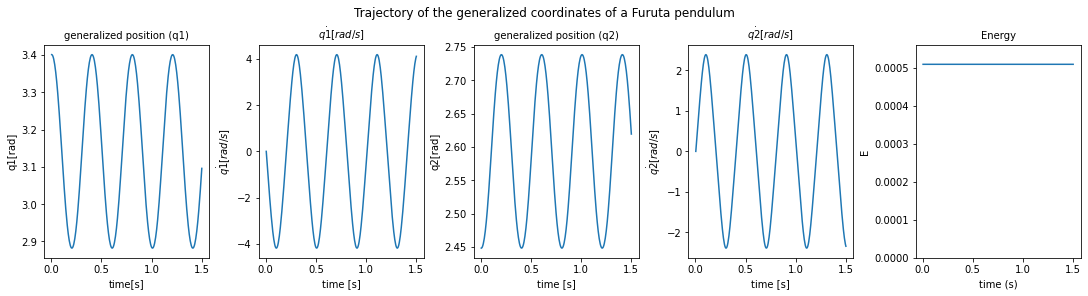

In [27]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(utype='step', gtype='simple', init_method = 'random_closetopi', time_steps=300,
                          num_trajectories=5, u_func=None, g_func=None, 
                          y0=None, Ts = Ts,noise_std=0.0, C_q1 = C_q1,
                           C_q2 = C_q2,g = g , Jr = Jr, Lr = Lr, Mp = Mp , Lp = Lp)

plot_traj_furuta(t_eval, q1[0,:], p1[0,:], q2[0,:], p2[0,:], energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum')

plot_traj_furuta(t_eval, q1[0,:], derivatives[0,:,0], q2[0,:], derivatives[0,:,2], energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='newtonian')

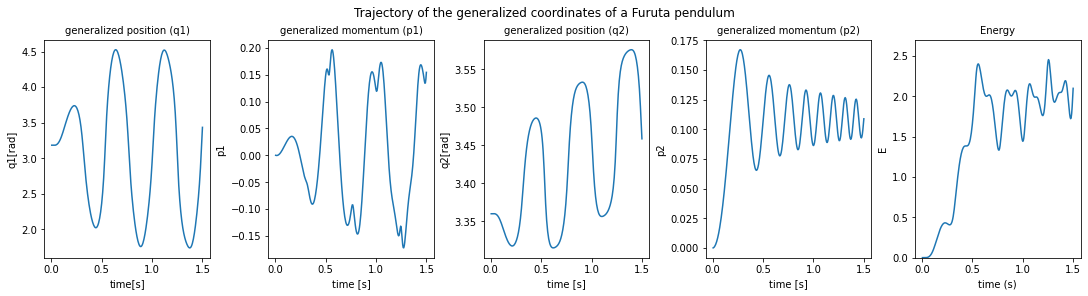

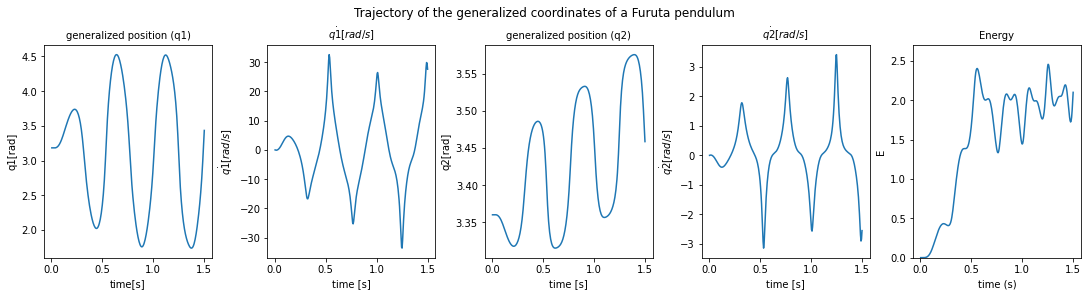

In [28]:
Ts = 0.005
noise_std = 0.0
C_q1 = 0.002
C_q2 = 0.002
g = 9.81
Jr = 1*1e-5
Lr = 0.5
Mp = 5.0
Lp = 0.1

# g = 9.81
# Jr = 5.72*1e-5
# Lr = 0.085
# Mp = 0.024
# Lp = 0.129

q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(utype='CHIRP', gtype='simple', init_method = 'random_closetopi',time_steps=300,
                          num_trajectories=5, u_func=u_func, g_func=g_func, 
                          y0=None, Ts = Ts, noise_std=0.0, C_q1 = C_q1,
                           C_q2 = C_q2,g = g , Jr = Jr, Lr = Lr, Mp = Mp , Lp = Lp)

plot_traj_furuta(t_eval, q1[0,:], p1[0,:], q2[0,:], p2[0,:], energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum')

plot_traj_furuta(t_eval, q1[0,:], derivatives[0,:,0], q2[0,:], derivatives[0,:,2], energy[0,:],
                 title = 'Trajectory of the generalized coordinates of a Furuta pendulum', coord_type='newtonian')

In [29]:
print(q1.std(),derivatives[:,:,0].std(),q2.std(),derivatives[:,:,2].std())

tensor(0.9554) tensor(12.8355) tensor(0.9237) tensor(1.0859)


In [30]:
print(q1.shape) 
print(energy.shape)
print(derivatives.shape)
print(t_eval.shape)

torch.Size([5, 300])
torch.Size([5, 300])
torch.Size([5, 300, 4])
torch.Size([300])


### Dataset & Dataloader

In [31]:
class TrajectoryDataset_furuta(Dataset):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    def __init__(self, u, q1, p1, q2, p2, t_eval, #energy=torch.tensor(False), 
                 derivatives, coord_type='hamiltonian' ):
        self.t_eval = t_eval
        self.coord_type = coord_type
        self.q1 = q1 # [num_trajectories, time_steps]
        self.p1 = p1
        self.q2 = q2
        self.p2 = p2
        self.u = u
        # if energy:
        #    self.energy = energy
        #if derivatives:
        self.dq1dt = derivatives[:,:,0] # [num_trajectories, time_steps, (dq1/dt,dp1/dt,dq2/dt,dp2/dt)]
        #self.dp1dt = derivatives[:,:,1]
        self.dq2dt = derivatives[:,:,2]
        #self.dp2dt = derivatives[:,:,4]
        
    def __len__(self):
        return len(self.q1)

    def __getitem__(self, idx):
        
        if self.coord_type == 'hamiltonian':

            q1 = self.q1[idx]
            p1 = self.p1[idx]
            q2 = self.q2[idx]
            p2 = self.p2[idx]
            
            x = torch.vstack((q1,p1,q2,p2))
            
        if self.coord_type == 'newtonian':

            q1 = self.q1[idx]
            q2 = self.q2[idx]
            dq1dt = self.dq1dt[idx]
            dq2dt = self.dq2dt[idx]
            
            x = torch.vstack((q1,dq1dt,q2,dq2dt))
            
        t_eval = self.t_eval
        u = self.u
        
        return u, x, t_eval

In [32]:
def data_loader_furuta(u, q1, p1, q2, p2, energy, derivatives, t_eval, batch_size,
                       shuffle = True, proportion = 0.5, coord_type='newtonian'):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # split  into train and test 
    full_dataset = TrajectoryDataset_furuta(u, q1, p1, q2, p2, t_eval,derivatives, coord_type=coord_type)
    if proportion:

        train_size = int(proportion * len(full_dataset))
        test_size = len(full_dataset) - train_size

        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
        
        test_loader = DataLoader(
            test_dataset,
            batch_size,
            shuffle
            )    
    else:
      # if proportion is set to None don't split the dataset
        train_dataset = full_dataset
        energy_train = energy
        derivatives_train = derivatives
        t_eval_train = t_eval
        test_loader = None

    # create the dataloader object from the custom dataset
    train_loader = DataLoader(
        train_dataset,
        batch_size,
        shuffle
        )
       
    return train_loader, test_loader

In [33]:
# Ts = 0.005
# noise_std = 0.0
# C_q1 = 0.0
# C_q2 = 0.0
# g = 9.81
# Jr = 5.72*1e-5
# Lr = 0.085
# Mp = 0.024
# Lp = 0.129

In [34]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(utype='CHIRP', gtype='simple', init_method = 'random_closetopi', time_steps=500,
                          num_trajectories=10, u_func=u_func, g_func=g_func, 
                          y0=None, Ts = Ts, noise_std=0.0, C_q1 = C_q1,
                           C_q2 = C_q2,g = g , Jr = Jr, Lr = Lr, Mp = Mp , Lp = Lp)
u = u_func(t_eval)

# train_loader, test_loader = data_loader_furuta(u, q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=3,
#                        shuffle = True, proportion = 0.5, coord_type='newtonian')

In [35]:
train_loader, test_loader = data_loader_furuta(u, q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=10,
                       shuffle = True, proportion = 0.0, coord_type='hamiltonian')

In [36]:
energy.shape

torch.Size([10, 500])

torch.Size([10, 4, 500])


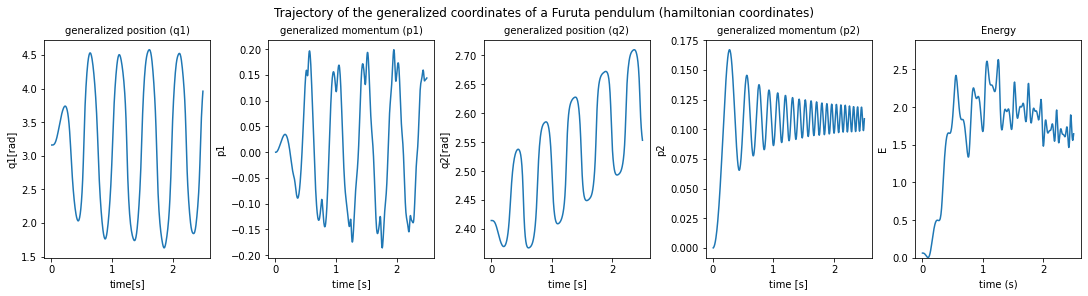

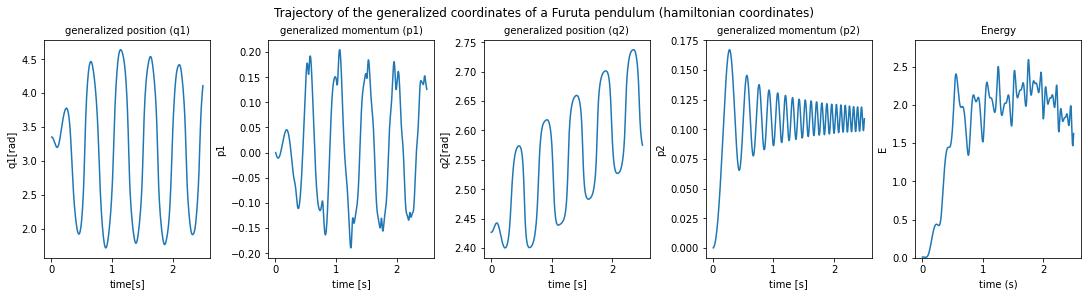

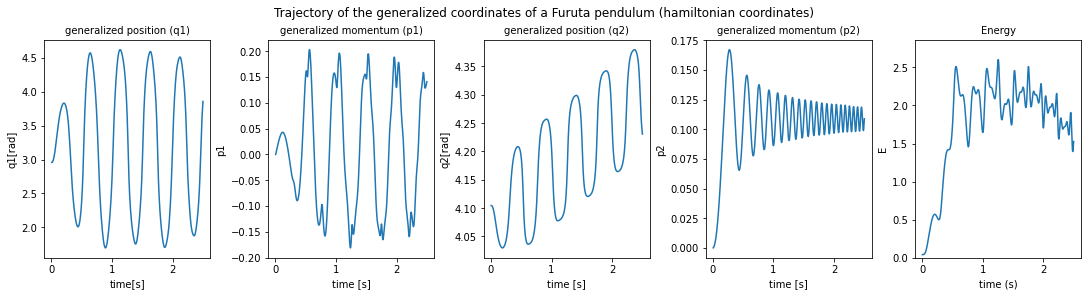

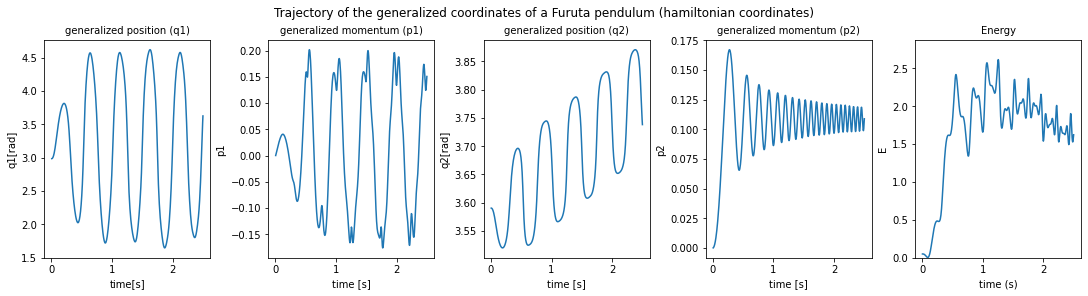

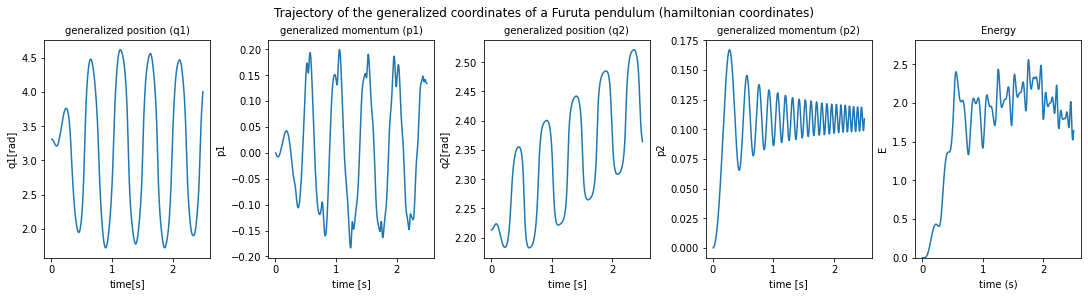

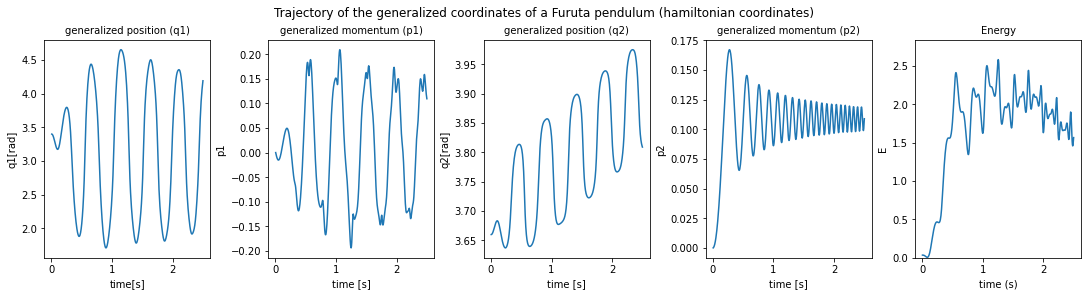

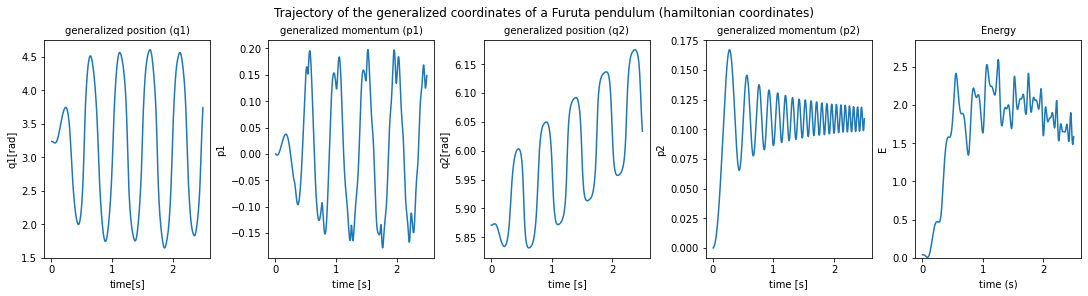

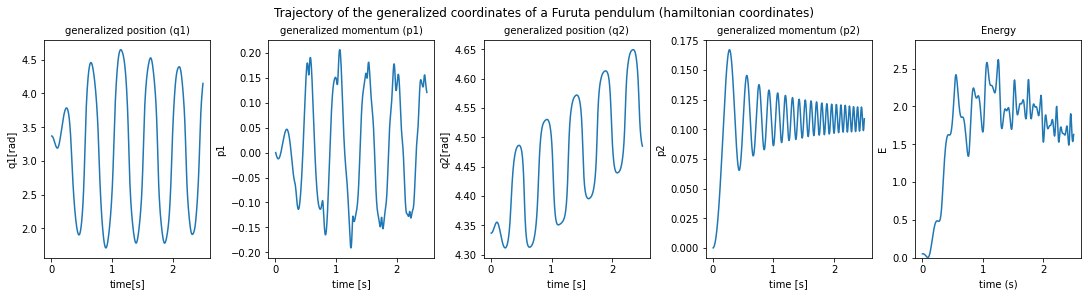

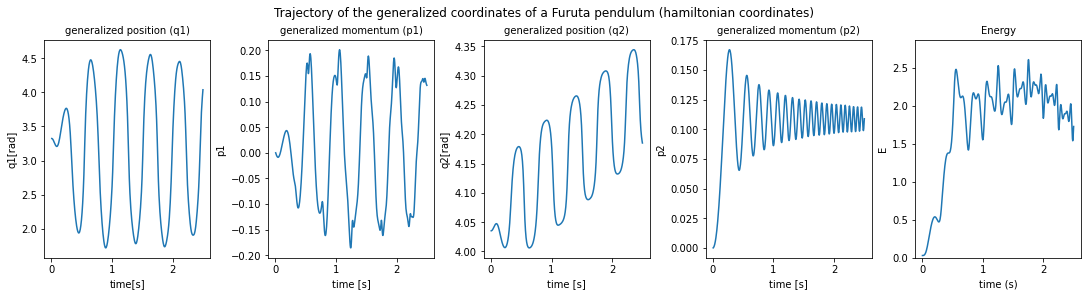

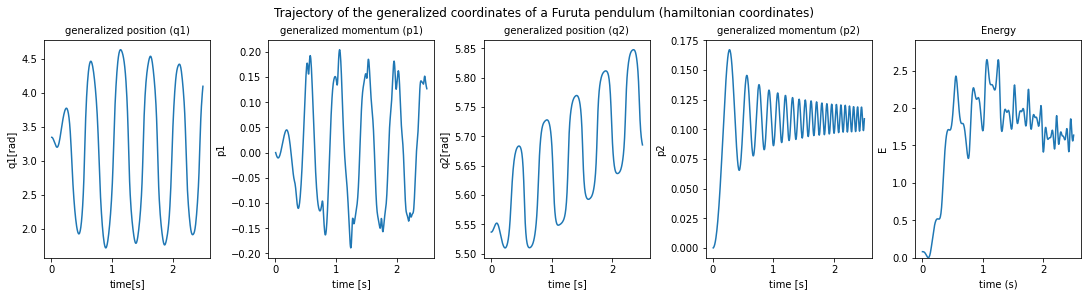

In [37]:
# sanity checks
u_tt, x_tt, t_eval_tt = next(iter(train_loader))
print(x_tt.shape)
for n in range(10):
    q1_t = x_tt[n,0,:]
    p1_t = x_tt[n,1,:]
    q2_t = x_tt[n,2,:]
    p2_t = x_tt[n,3,:]

    plot_traj_furuta(t_eval_tt[n], q1_t, p1_t, q2_t, p2_t,energy[n,:],
                    title = 'Trajectory of the generalized coordinates of a Furuta pendulum (hamiltonian coordinates)', coord_type='hamiltonian')

## Utils

In [38]:
def count_parameters(model):
    '''
    from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    Description:

    Inputs:

    Outpus:
      
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### Plot functions for train & test

In [39]:
def plot_furuta_hat_nom(u_func, g_func, data_loader_t,n,t_max, C_q1, C_q2, g, Jr, Lr, Mp, Lp,
                        title = 'Trajectory of the generalized coordinates'#, coord_type='hamiltonian'
                     , file_path=None):
    '''
    Description:
      This function plots the generalised variables q p, the energy at the time
      t_eval at which they were evaluated
    Inputs:
      t_eval ()
      q ()
      p () 
    Outputs:
      None
    '''
    x_nom, t_eval = next(iter(data_loader_t))

    t_eval = t_eval[0,:] # otherwise it is by batch
    time_steps = len(t_eval)
    Ts = t_eval[0]
    # predicted trajectory
    x_hat = odeint(model, x_nom[:, :, 0], t_eval[0,:], method='rk4').detach()
    x_hat = x_hat.detach()

    q1_hat = x_hat[:,n,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[:,n,1]
    q2_hat = x_hat[:,n,2]
    p2_hat = x_hat[:,n,3]

    E_hat, _ = get_energy_furuta(time_steps, Ts, u_func, g_func, q1_hat, p1_hat, q2_hat, p2_hat, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_hat = furuta_H(q1_hat, p1_hat, q2_hat, p2_hat, g, Jr, Lr, Mp, Lp)
    # H_hat = model.H_net(x_hat[:,0,:]).detach().squeeze()

    # nominal trajectory
    q1_nom = x_nom[n,0,:]
    p1_nom = x_nom[n,1,:]
    q2_nom = x_nom[n,2,:]
    p2_nom = x_nom[n,3,:]

    E_nom, _ = get_energy_furuta(time_steps, Ts, u_func, g_func, q1_nom, p1_nom, q2_nom, p2_nom, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom, g, Jr, Lr, Mp, Lp)

    


    fig, ax = plt.subplots(2, 3, figsize=(15, 4), constrained_layout=True, sharex=True)# , sharey=True)

    # to do : make a for loop to add multiple plots
    # predicted
    # plot nominal and predicted trajectory on same plot
    #

    # for x in [t_eval, q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat, q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom] :
    #     x = x.detach().cpu() # transfering everything to cpu memory
    #     print(x.device)
    t_eval = t_eval.cpu()


    for q1, p1, q2, p2, E, H, label in [[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[1,0].plot(t_eval, p1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)
        ax[1,1].plot(t_eval, p2, label=label)
        ax[0,2].plot(t_eval, E, label=label)
        ax[1,2].plot(t_eval, H, label=label)



    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'prediction']]:
      
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        ax[0,0].plot(t_eval[:t_max], q1[:t_max], label='train', c='g')
        ax[0,0].plot(t_eval[t_max-1:], q1[t_max-1:], label=label, c='r')

        ax[1,0].plot(t_eval[:t_max], p1[:t_max], label='train', c='g')
        ax[1,0].plot(t_eval[t_max-1:], p1[t_max-1:], label=label, c='r')

        ax[0,1].plot(t_eval[:t_max], q2[:t_max], label='train', c='g')
        ax[0,1].plot(t_eval[t_max-1:], q2[t_max-1:], label=label, c='r')

        ax[1,1].plot(t_eval[:t_max], p2[:t_max], label='train', c='g')
        ax[1,1].plot(t_eval[t_max-1:], p2[t_max-1:], label=label, c='r')

        ax[0,2].plot(t_eval[:t_max], E[:t_max], label='train', c='g')
        ax[0,2].plot(t_eval[t_max-1:], E[t_max-1:], label=label, c='r')

        ax[1,2].plot(t_eval[:t_max], H[:t_max], label='train', c='g')
        ax[1,2].plot(t_eval[t_max-1:], H[t_max-1:], label=label, c='r')






    # for j in range(3): # show all of the legends
    #   for i in range(2):
    
    ax[0,0].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[1,0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel('p1')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')

    ax[1,1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel('p2')

    ax[0,2].set_title('Energy', fontsize=10)
    ax[0,2].set_xlabel('time (s)')
    ax[0,2].set_ylabel('E')
    #ax[0,2].set_ylim(bottom=0)
    #ax[0,2].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    ax[1,2].set_title('Hamiltonian', fontsize=10)
    ax[1,2].set_xlabel('time (s)')
    ax[1,2].set_ylabel('H')

    # add larger title on top
    fig.suptitle(title, fontsize=12)

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return

In [40]:
def plot_longer_horizon_furuta(u_func, g_func, test_loader, t1, t2, C_q1, C_q2, g, Jr, Lr, Mp, Lp, 
                               title = 'Trajectory after longer horizon', file_path=None,):
    '''

    Description:

    Inputs:

    Outpus:
      
    '''
    x_nom, t_eval = next(iter(test_loader))

    t_eval = t_eval[0,t1:t2]

    time_steps = len(t_eval)
    Ts = t_eval[0]

    # test trajectories
    x_hat = odeint(model, x_nom[:, :, 0], t_eval[0,:], method='rk4').detach()
    x_hat = x_hat.detach()

    q1_hat = x_hat[t1:t2,0,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[t1:t2,0,1]
    q2_hat = x_hat[t1:t2,0,2]
    p2_hat = x_hat[t1:t2,0,3]

    E_hat, _ = get_energy_furuta(time_steps, Ts, u_func, g_func, q1_hat, p1_hat, q2_hat, p2_hat, C_q1, C_q2, g, Jr, Lr, Mp, Lp) 
    H_hat = furuta_H(q1_hat, p1_hat, q2_hat, p2_hat, g, Jr, Lr, Mp, Lp)
    # H_hat = model.H_net(x_hat[t1:t2,0,:]).detach().squeeze()

    # nominal trajectories
    q1_nom = x_nom[0,0,t1:t2]
    p1_nom = x_nom[0,1,t1:t2]
    q2_nom = x_nom[0,2,t1:t2]
    p2_nom = x_nom[0,3,t1:t2]

    E_nom, _ = get_energy_furuta(time_steps, Ts, u_func, g_func, q1_nom, p1_nom, q2_nom, p2_nom, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom, g, Jr, Lr, Mp, Lp)


    fig, ax = plt.subplots(2, 2, figsize=(15, 6), constrained_layout=True, sharex=True)# , sharey=True)

    t_eval = t_eval.cpu()
    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'prediction'],[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)

        ax[1,0].plot(t_eval, E, label=label)
        ax[1,0].set_title('Energy', fontsize=10)
        ax[1,0].set_xlabel('time (s)')
        ax[1,0].set_ylabel('E')
          
        ax[1,1].plot(t_eval, H, label=label)
        ax[1,1].set_title('Hamiltonian', fontsize=10)
        ax[1,1].set_xlabel('time (s)')
        ax[1,1].set_ylabel('H')

    #ax[1,0].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    # for j in range(2): # show all of the legends
    #   for i in range(2):
    #     ax[i,j].legend()
    ax[0,1].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')
    fig.suptitle(title, fontsize=12)
    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return 

In [41]:
def train_test_loss_plot(loss_train,loss_test, epochs, file_path=None,
                            horizons = [100,150,200,250,300],
                            horizon_steps = [200,400,550,700,850],
                            title='train and test loss per epoch' ):
    ''' 
    Description:

    Inputs:

    Outpus:

    '''
    fig, ax = plt.subplots(figsize=(10,4))
    # ,constrained_layout=True)
    # fig.tight_layout()

    plt.plot(epochs, loss_train, label='train')

    if not loss_test == []: # if loss_test exists
        plt.plot(epochs[::10], loss_test, label='test')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend()
    plt.title(title)

    if horizons:
        for i, epoch_num in enumerate(horizon_steps[:-1]):
            ax.annotate(
            'horizon = %d'%horizons[i],
            xy=(epochs[epoch_num], loss_train[epoch_num]), xycoords='data',
            xytext=(-70, 100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc,angleA=0,armA=50,rad=10"
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"
                            ))
        ax.annotate(
        'horizon = %d'%horizons[-1],
        xy=(epochs[horizon_steps[-1]], loss_train[horizon_steps[-1]]), xycoords='data',
        xytext=(+20, 100), textcoords='offset points',
        arrowprops=dict(arrowstyle="->",
                        #connectionstyle="arc,angleA=0,armA=50,rad=10"
                        connectionstyle="angle,angleA=0,angleB=90,rad=10"
                        ))

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
   
    return

## Models

### Base models

In [42]:
def choose_nonlinearity(name):
    '''
    From the SymODEN repository

    Description:

    Inputs:

    Outpus:
      
    '''
    nl = None
    if name == 'tanh':
        nl = torch.tanh
    elif name == 'x+sin(x)^2':
        nl = lambda x: x + torch.sin(x).pow(2)
    else:
        raise ValueError("nonlinearity not recognized")
    return nl

In [43]:
class hidden_Layer(torch.nn.Module):
    '''
    Fully connected layer with activation function
    '''
    def __init__(self,hidden_dim, activation='tanh'):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_dim,hidden_dim)
        self.activation = choose_nonlinearity(activation)# activation function

    def forward(self, x):
        x=self.activation(self.fc(x))
        return x

In [44]:
class MLP(torch.nn.Module):
    '''
    MLP with number of hidden layers as a parameter
    '''
    def __init__(self, input_dim=2, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2'):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = torch.nn.Sequential(
            *(hidden_Layer(hidden_dim, activation)
              for _ in range(nb_hidden_layers))
        ) # trick from EE-559 to define hidden layers
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = choose_nonlinearity(activation) # activation function

    def forward(self, x, separate_fields=False):
        h = self.activation( self.fc1(x) )
        h = self.hidden_layers(h) 
        return self.fc2(h)

### MLP_U_HNN

In [45]:
torch.tensor([0.02]).sqrt().pow(2)

tensor([0.0200])

In [46]:
class Simple_MLP(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module from symoden repository
    Similar to unconstrained ODE HNN from the report

    '''
    def __init__(self, input_dim, H_net=None, device=None):
        super(Simple_MLP, self).__init__()
        self.H_net = H_net

        self.device = device
        self.input_dim = input_dim
        
        # add learnable dissipation coefficients
        self.C1_dissip = torch.nn.Parameter(torch.tensor([0.02]).sqrt()) # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C1_dissip.requires_grad = True
        self.C2_dissip = torch.nn.Parameter(torch.tensor([0.02]).sqrt()) # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C2_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            # q1,p1,q2,p2 = torch.chunk(x,4,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            # .sum() to sum up the hamiltonian funcs of a batch
            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq1 , dHdp1, dHdq2 , dHdp2 = torch.chunk(dH,4,dim=-1)

            dq1dt = dHdp1
            dp1dt = -dHdq1 - self.C1_dissip.pow(2)*dHdp1
            dq2dt = dHdp2
            dp2dt = -dHdq2 - self.C2_dissip.pow(2)*dHdp2

            # symplectic gradient 
            S_h = torch.cat((dq1dt, dp1dt, dq2dt, dp2dt), 
                            dim=-1) 

            return S_h

### Nes_HDNN

In [47]:
class Nes_HDNN(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module from symoden repository
    Similar to unconstrained ODE HNN from the report

    '''
    def __init__(self, utype='CHIRP', u_func = None, G_net=None, H_net=None, device=None):
        super(Nes_HDNN, self).__init__()
        self.H_net = H_net
        self.G_net = G_net
        self.u_func = u_func
        self.utype = utype
        self.device = device
        
        # add learnable dissipation coefficients
        self.C1_dissip = torch.nn.Parameter(torch.tensor([0.02]).sqrt()) # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C1_dissip.requires_grad = True
        self.C2_dissip = torch.nn.Parameter(torch.tensor([0.02]).sqrt()) # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C2_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            # q1,p1,q2,p2 = torch.chunk(x,4,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            # .sum() to sum up the hamiltonian funcs of a batch
            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq1 , dHdp1, dHdq2 , dHdp2 = torch.chunk(dH,4,dim=-1)

            G = self.G_net(q_p)

            if self.u_func:
                u = self.u_func(t,self.utype)
            else:
                u = torch.tensor([0.0])
            dq1dt = dHdp1 + (G[:,0].T*u).unsqueeze(dim=1)
            dp1dt = -dHdq1 + (G[:,2].T*u).unsqueeze(dim=1) # - self.C1_dissip.pow(2)*dHdp1 
            dq2dt = dHdp2 + (G[:,1].T*u).unsqueeze(dim=1)
            dp2dt = -dHdq2 + (G[:,3].T*u).unsqueeze(dim=1) # - self.C2_dissip.pow(2)*dHdp2 

            # symplectic gradient 
            S_h = torch.cat((dq1dt, dp1dt, dq2dt, dp2dt), 
                            dim=-1) 
            
            return S_h

    def freeze_G_net(self, freeze=True): 
        """
        Only freez the G_net parameters
        Inputs
            freeze(bool) : True = freeze the parameters; False = don't
        
        outputs:
            None

        """
        for param in self.G_net.parameters(): 
            param.requires_grad = (not freeze)

    def freeze_H_net(self, freeze=True): 
        """
        Only freez the H_net parameters
        Inputs
            freeze(bool) : True = freeze the parameters; False = don't
      
        outputs:
            None
        """
        for param in self.H_net.parameters(): 
            param.requires_grad = (not freeze)

In [48]:
G_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=2, output_dim=4, activation='tanh')
H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2')
model_Nes_HDNN = Nes_HDNN(u_func=u_func, G_net=G_net, H_net=H_net, device=device)

In [49]:
print(u_tt.shape)
print(x_tt.shape)
print(t_eval_tt.shape)

torch.Size([10, 500])
torch.Size([10, 4, 500])
torch.Size([10, 500])


In [50]:
S_h = model_Nes_HDNN(t_eval_tt[:,0],x_tt[:,:,0])
S_h.shape

torch.Size([10, 4])

### Autoencoder

In [51]:
class Autoencoder(torch.nn.Module):
    '''
    '''
    def __init__(self, nb_hidden_layers=1,  hidden_dim=64, activation='tanh', config = 'latent'):
        super(Autoencoder, self).__init__()
        
        self.config = config
        if self.config == 'latent':
                enc_in_dim = 4
                enc_out_dim = 2
                dec_in_dim = 4
                dec_out_dim = 4

        elif self.config == 'encoded':
                enc_in_dim = 4
                enc_out_dim = 4
                dec_in_dim = 4
                dec_out_dim = 4

        self.encoder = MLP(input_dim=enc_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=enc_out_dim, activation=activation)
        
        self.decoder = MLP(input_dim=dec_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=dec_out_dim, activation=activation)

    def forward(self, x): # x is (q, q_dot)

        if self.config == 'latent':
                q1, p1, q2, p2 = torch.split(x,1,dim=-1)

                p_hat = self.encoder(x) # coordinates in the latent space

                z = torch.stack((q1[:,:,0],p_hat[:,:,0],q2[:,:,0],p_hat[:,:,1]),dim=2) # input known q and encoded z into decoder
                
                x_hat = self.decoder(z) # coordinates back in the original space but using the decoder

                # x_hat = torch.stack((q1[:,:,0],q_dot_hat[:,:,0],q2[:,:,0],q_dot_hat[:,:,1]),dim=2)

                # x_hat = torch.stack((q1[:,:,0],q_dot_hat[:,:,0],q2[:,:,0],q_dot_hat[:,:,1]),dim=2)
        if self.config == 'encoded':
                z = self.encoder(x)
                x_hat = self.decoder(z)

        return z , x_hat

## Training

### Simple MLP with Increasing Horizon method : like Jonas

##### Train functions : 

In [52]:
def L2_loss(u, v, w = False, dim = (0,1), param = 'L2'):
    # u nominal
    # v approximate
    # u and v expected with shape : [time_steps, batch_size , (q1,p1,q2,p1)] 

    if param == 'L2weighted':
        # mean only over time steps and batch_size 
        loss = (((u-v)).pow(2)).mul(w).mean(dim = dim ).sum()
    elif param == 'L2':
        loss = (((u-v)).pow(2)).mean(dim = dim ).sum()
    elif param == 'L2weighted2':
        loss = (((u-v).mul(w)).pow(2)).mean(dim = dim ).sum()
    elif param == 'L2normalized':
        # formula : (u-v)/v
        # +1e-10 for stability in case of a zero # still not enough because loss on p1 explodes 
        # when nominal close to zero and predicted is far from zero
        loss = ((u.sub(v).div(u+1e-10)).pow(2)).mean(dim = dim ).sum()
    elif param == 'L2normalizedfixed':
        loss = ((u[:,:,:3].sub(v[:,:,:3]).div(u[:,:,:3]+1e-10)).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[:,:,3].sub(v[:,:,3])).pow(2)).mean(dim = dim ).sum()

    elif param == 'L2normalizedfixed2':
        # loss = ((u[1:,:,0].sub(v[1:,:,0]).div(u[1:,:,0]+1e-10)).mul(w[0]).pow(2)).mean(dim = dim ).sum()
        # loss = loss + ((u[1:,:,2].sub(v[1:,:,2]).div(u[1:,:,2]+1e-10)).mul(w[2]).pow(2)).mean(dim = dim ).sum()

        loss = ((u[1:,:,0].sub(v[1:,:,0]).div(w[0])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,2].sub(v[1:,:,2]).div(w[2])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,1].sub(v[1:,:,1]).div(w[1])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,3].sub(v[1:,:,3]).div(w[3])).pow(2)).mean(dim = dim ).sum()

    elif param == 'L2normalizedfixed3':
        loss =        ((u[1:,:,0].sub(v[1:,:,0]).div(u[1:,:,0]+1e-5)).mul(w[0]).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,1].sub(v[1:,:,1]).mul(w[1])                     ).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,2].sub(v[1:,:,2]).div(u[1:,:,2]+1e-5)).mul(w[2]).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,3].sub(v[1:,:,3]).mul(w[3])                     ).pow(2)).mean(dim = dim ).sum()
        # loss = (1/4)*loss 

    elif param == 'L2normalizedfixed4': # division by std per trajectory bad some trajectory has tiny std that makes it explode
        std = u.std(dim=0)
        loss =        ((u[1:,:,0].sub(v[1:,:,0]).div(u[1:,:,0]+1e-10)).mul(w[0]).pow(2)).mean(dim = dim ).sum() 
        loss = loss + ((u[1:,:,1].sub(v[1:,:,1]).div(std[:,1]).mul(w[1])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,2].sub(v[1:,:,2]).div(std[:,2]).mul(w[2])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,3].sub(v[1:,:,3]).mul(w[3])).pow(2)).mean(dim = dim ).sum()

    elif param == 'L2normalizedfixed5':
        std = u.std(dim=0)
        loss =        ((u[1:,:,0].sub(v[1:,:,0]).div(std[:,0]).mul(w[0])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,1].sub(v[1:,:,1]).div(std[:,1]).mul(w[1])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,2].sub(v[1:,:,2]).div(std[:,2]).mul(w[2])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,3].sub(v[1:,:,3]).mul(w[3])).pow(2)).mean(dim = dim ).sum()

    elif param == 'minmax': 
        std = u.std(dim=0)
        loss = 0
        for i in range(3):
            loss_t =  (u[1:,:,i].sub(v[1:,:,i])).mul(w[i])
            min = loss_t.min()
            max = loss_t.max()
            loss_t = (loss_t.div(max-min).pow(2)).mean(dim = dim ).sum()
            loss = loss + loss_t

        loss4 =  ((u[1:,:,3].sub(v[1:,:,3]).mul(w[3])).pow(2)).mean(dim = dim ).sum()  
        
    # funkyloss is bad because log diverges when u close to v ( because of log of small number)
    # elif param =='funkyloss': 
    # loss = torch.log((u[1:,:,:].sub(v[1:,:,:]).div(u[1:,:,:]+1e-10)).abs()).pow(2).mean(dim = dim ).sum()

    return loss

In [53]:
def load_model(hidden_dim=90, nb_hidden_layers=4):
    H_net = MLP(input_dim=4, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers, output_dim=1, activation='x+sin(x)^2')
    model = Simple_MLP(input_dim=4, H_net=H_net, device=None) 
    model.to(device) 
    return model

In [54]:
def load_model_nes_hdnn(utype, u_func=None, hidden_dim=90, nb_hidden_layers=4):

    G_net = MLP(input_dim=4, hidden_dim=64, nb_hidden_layers=1, output_dim=4, activation='tanh')
    H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2')
    model = Nes_HDNN(utype=utype, u_func=u_func, G_net=G_net, H_net=H_net, device=device)

    model.to(device) 

    return model 

In [55]:
def load_data_device(device, utype, gtype, init_method, u_func=None, g_func=None, time_steps=40, num_trajectories=10, shuffle = False,
                     coord_type='hamiltonian', proportion=0.5, batch_size=1, 
                     Ts = 0.005, noise_std=0.0, C_q1=0.0, C_q2=0.0, 
                     g = 9.81, Jr = 1*1e-5, Lr = 0.5, Mp = 5.0, Lp = 0.5):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # create trajectories
    q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(utype, gtype, init_method, time_steps, num_trajectories, u_func, g_func,
                          None, Ts , noise_std, C_q1, C_q2, g, Jr,  Lr,  Mp, Lp)

    q1 = q1.to(device)
    p1 = p1.to(device)
    q2 = q2.to(device)
    p2 = p2.to(device)
    energy = energy.to(device)
    derivatives = derivatives.to(device)
    t_eval = t_eval.to(device)
    u = u_func(t_eval).to(device)
    stds = torch.tensor([q1.std(),p1.std(),q2.std(),p2.std()])
    # dataloader to load data in batches
    train_loader, test_loader = data_loader_furuta(u, q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=batch_size,
                          shuffle = shuffle, proportion = proportion, coord_type=coord_type)
    return train_loader, test_loader, stds

In [56]:
def select_horizon_list(step, horizon_list = [50,100,150,200,250,300], switch_steps = [200,200,200,150,150,150]):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # throw error if 
    assert len(horizon_list)==len(switch_steps), ' horizon_list and switch_steps must have same length'

    if step <=switch_steps[0]:
        horizon = horizon_list[0]
        if step==0:
            print('horizon length :', horizon)

    for i in range(len(switch_steps)):
      if (step > sum(switch_steps[0:i]))&(step <= sum(switch_steps[0:i+1])):
          horizon = horizon_list[i]
          if step==sum(switch_steps[0:i])+1:
              print('horizon length :', horizon)

    if step > sum(switch_steps):
        horizon = horizon_list[-1]
        if step== sum(switch_steps)+1:
            print('horizon length :', horizon)
    return horizon 

In [57]:
def select_horizon_wschedule(step,optim,epoch_number, 
                             switch_steps = (200,200,150,150,150)       
                            ):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    n1, n2, n3, n4, n5 = switch_steps
    # n1 number of steps with a horizon =  50
    # n2 number of steps with a horizon =  100
    # n3 number of steps with a horizon =  150
    # n4 number of steps with a horizon =  200
    # n5 number of steps with a horizon =  250
    # horizon = 300 for the remainder of training steps 

    if step <=n1:
        horizon = 50
        if step==0:
            print('horizon length :', horizon)
            # steps = n1
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0   
        do_step = False
            
    elif (step > n1)&(step <= n1+n2):
        horizon = 100
        if step==n1+1:
            print('horizon length :', horizon)
            # steps = n2
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0   
        do_step = False
    elif (step > n1+n2)&(step <= n1+n2+n3):
        horizon = 150
        if step==n1+n2+1:
            print('horizon length :', horizon)
            # steps = n3
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0   
        do_step = False
    elif (step > n1+n2+n3)&(step <= n1+n2+n3+n4):
        horizon = 200
        if step==n1+n2+n3+1:
            print('horizon length :', horizon)
            # steps = n4
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0     
        do_step = False
    elif (step > n1+n2+n3+n4)&(step <= n1+n2+n3+n4+n5):
        horizon = 250
        if step==n1+n2+n3+n4+1:
            print('horizon length :', horizon)
            # steps = n5
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0     
        do_step = False
    else :
        horizon = 300
        do_step = True
        num_steps = 0
        if step==n1+n2+n3+n4+n5+1:
            print('horizon length :', horizon)
            num_steps = epoch_number - (n1+n2+n3+n4+n5)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, num_steps)

    return horizon, num_steps

In [58]:
def training_plot(t_eval, train_x, nominal_x):
    # train_x is [batch_size,(q1,p1,q2,p1),time_steps]
    # nominal_x is [time_steps, batch_size, (q1,p1,q2,p1)]

    fig, ax = plt.subplots(2, 2, figsize=(10, 5), constrained_layout=True, sharex=True)# , sharey=True)
    t_eval_cpu = t_eval.detach().cpu()
    ax[0,0].plot(t_eval_cpu, train_x[:,0,0].detach().cpu(), label='train', c='g')
    ax[1,0].plot(t_eval_cpu, train_x[:,0,1].detach().cpu(), label='train', c='g')
    ax[0,1].plot(t_eval_cpu, train_x[:,0,2].detach().cpu(), label='train', c='g')
    ax[1,1].plot(t_eval_cpu, train_x[:,0,3].detach().cpu(), label='train', c='g')

    ax[0,0].plot(t_eval_cpu, nominal_x[0,0,:].detach().cpu(), label='nominal')
    ax[1,0].plot(t_eval_cpu, nominal_x[0,1,:].detach().cpu(), label='nominal')
    ax[0,1].plot(t_eval_cpu, nominal_x[0,2,:].detach().cpu(), label='nominal')
    ax[1,1].plot(t_eval_cpu, nominal_x[0,3,:].detach().cpu(), label='nominal')

    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[1,0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel('p1')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')

    ax[1,1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel('p2')
    ax[1,1].legend()
    
    # add larger title on top
    fig.suptitle('intermediate plot of trajectories', fontsize=12)

    plt.show()
    return

In [59]:
def train(model, Ts, train_loader, test_loader, horizon=False, horizon_type=False,
          horizon_list = [50,100,150,200,250,300], 
          switch_steps = [200,200,200,150,150,150],
          epochs = 20, 
          w=torch.tensor([0.1,0.1,1.0,1.0], device=device),
          loss_type = 'L2'):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps

    
    lr = 1e-3

    optim = torch.optim.AdamW(model.parameters(), lr, weight_decay=1e-4) # Adam

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        t1 = time.time()

        if horizon_type == 'schedule':
            horizon, num_steps= select_horizon_wschedule(step,optim,
                                                          epoch_number,
                                                          switch_steps)
            if num_steps :
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, num_steps)

        elif horizon_type == 'auto': 
            horizon = select_horizon_list(step, horizon_list, switch_steps)

        model.train()
        for u, x, t_eval in iter(train_loader): # we don't really need u since the model knows u_func
            # x is [batch_size,(q1,p1,q2,p1),time_steps]
            t_eval = t_eval[0,:horizon]

            train_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4', options=dict(step_size=Ts))            
            # train_x_hat is [time_steps, batch_size, (q1,p1,q2,p1)] 
            #train_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , train_x_hat[:horizon,:,:],w)#[:,:horizon])
            train_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , train_x_hat[:horizon,:,:], w, param = loss_type)
            # after permute x is [time_steps, batch_size, (q1,p1,q2,p1),]

            # loss(u, v, w = False, dim = (0,1), param = loss_type)
            if not step%10:
                t_plot = time.time()
                training_plot(t_eval, train_x_hat[:horizon,:,:], x[:, :, :horizon])
                print('plot time :' , time.time()-t_plot)

            train_loss = train_loss + train_loss_mini.item()

            train_loss_mini.backward() 
            optim.step() 
            optim.zero_grad()
            if (horizon == 'schedule') and do_step:
              scheduler.step()


        t2 = time.time()
        train_time = t2-t1

        model.eval()
        if test_loader: 
            with torch.no_grad(): # we won't need gradients for testing
                if not (step%10): # run validation every 10 steps
                    for u, x, t_eval in iter(test_loader):
                        # run test data
                        t_eval = t_eval[0,:horizon]
      
                        test_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4', options=dict(step_size=Ts))      
                        #test_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
                        test_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:], w, param = loss_type)
              

                        test_loss = test_loss + test_loss_mini.item()
                    test_time = time.time()-t2
                    print('epoch {:4d} | train time {:.2f} | train loss {:8e} | test loss {:8e} | test time {:.2f}  '
                          .format(step, train_time, train_loss, test_loss,test_time))
                    stats['test_loss'].append(test_loss)
                    
                else:
                    print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                          .format(step, train_time, train_loss))
        else:
            print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                  .format(step, train_time, train_loss))
        
        # logging
        stats['train_loss'].append(train_loss)
    return stats

In [60]:
def train_alternating(model, Ts, train_loader, test_loader, horizon=False, horizon_type=False,
          horizon_list = [50,100,150,200,250,300], 
          switch_steps = [200,200,200,150,150,150],
          epochs = 20, 
          w=torch.tensor([0.1,0.1,1.0,1.0], device=device),
          loss_type = 'L2'):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps

    
    lr = 1e-3

    optim = torch.optim.AdamW(model.parameters(), lr, weight_decay=1e-4) # Adam

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        t1 = time.time()

        if horizon_type == 'schedule':
            horizon, num_steps= select_horizon_wschedule(step,optim,
                                                          epoch_number,
                                                          switch_steps)
            if num_steps :
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, num_steps)

        elif horizon_type == 'auto': 
            horizon = select_horizon_list(step, horizon_list, switch_steps)

        model.train()
        for u, x, t_eval in iter(train_loader): # we don't really need u since the model knows u_func
            # x is [batch_size,(q1,p1,q2,p1),time_steps]
            t_eval = t_eval[0,:horizon]

            for i in range(2):
                if i==0:
                    model.freeze_H_net(freeze=True)
                    model.freeze_G_net(freeze=False)
                elif i==1:
                    model.freeze_H_net(freeze=False)
                    model.freeze_G_net(freeze=True)

                train_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4', options=dict(step_size=Ts))            
                # train_x_hat is [time_steps, batch_size, (q1,p1,q2,p1)] 
                #train_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , train_x_hat[:horizon,:,:],w)#[:,:horizon])
                train_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , train_x_hat[:horizon,:,:], w, param = loss_type)
                # after permute x is [time_steps, batch_size, (q1,p1,q2,p1),]

                # loss(u, v, w = False, dim = (0,1), param = loss_type)
                if (not step%10)&(i==0):

                    t_plot = time.time()
                    training_plot(t_eval, train_x_hat[:horizon,:,:], x[:, :, :horizon])
                    print('plot time :' , time.time()-t_plot)

                train_loss = train_loss + train_loss_mini.item()

                train_loss_mini.backward() 
                optim.step() 
                optim.zero_grad()
                if (horizon == 'schedule') and do_step:
                  scheduler.step()

        t2 = time.time()
        train_time = t2-t1

        model.eval()
        if test_loader: 
            with torch.no_grad(): # we won't need gradients for testing
                if not (step%10): # run validation every 10 steps
                    for u, x, t_eval in iter(test_loader):
                        # run test data
                        t_eval = t_eval[0,:horizon]
      
                        test_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4', options=dict(step_size=Ts))      
                        #test_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
                        test_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:], w, param = loss_type)
              

                        test_loss = test_loss + test_loss_mini.item()
                    test_time = time.time()-t2
                    print('epoch {:4d} | train time {:.2f} | train loss {:8e} | test loss {:8e} | test time {:.2f}  '
                          .format(step, train_time, train_loss, test_loss,test_time))
                    stats['test_loss'].append(test_loss)
                    
                else:
                    print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                          .format(step, train_time, train_loss))
        else:
            print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                  .format(step, train_time, train_loss))
        
        # logging
        stats['train_loss'].append(train_loss)
    return stats

##### Training

In [61]:
device = set_device()

cpu


In [62]:
# device = 'cpu'

In [63]:
# The "fake" set of furuta parameters to have similar magnitudes in q1 p1 q2 p2
Ts = 0.005
# Ts = 0.003
noise_std = 0.0
C_q1 = 0.0
C_q2 = 0.0
# C_q1 = 0.02
# C_q2 = 0.02
g = 9.81
Jr = 1*1e-5
Lr = 0.5
Mp = 5.0
Lp = 0.1

In [64]:
# The set of furuta parameters similar to the real furuta
Ts = 0.005
# Ts = 0.003
noise_std = 0.0
C_q1 = 0.0
C_q2 = 0.0
# C_q1 = 0.02
# C_q2 = 0.02
g = 9.81
Jr = 5.72*1e-5
Lr = 0.085
Mp = 0.024
Lp = 0.129

In [ ]:
train_loader, test_loader, stds = load_data_device(device, utype='CHIRP', gtype='simple', init_method = 'random_closetopi', 
                                                   u_func=u_func, g_func=g_func, time_steps=800, 
                                                   shuffle = False, 
                                                   num_trajectories=125, 
                                                   coord_type='hamiltonian', 
                                                   proportion=0.8, batch_size=100, 
                                                   Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                                   g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp)

In [ ]:
u, x, t = next(iter(train_loader))

In [ ]:
suffix = 'Ts_{:.3f}_Jr_{:.2f}_Lr_{:.2f}_Mp_{:.2f}__Lp_{:.2f}'.format(Ts, Jr, Lr, Mp, Lp)
print(suffix)

In [ ]:
suffix = suffix + 'extra_'

In [ ]:
train_loader_path = PATH + 'data/train_loader_' + suffix + '.pt'
test_loader_path = PATH + 'data/test_loader_' + suffix + '.pt'

In [ ]:
torch.save(train_loader, train_loader_path)
if test_loader is not None:
    torch.save(test_loader, test_loader_path)

In [ ]:
train_loader = torch.load(train_loader_path)

test_loader = torch.load(test_loader_path)

In [ ]:
u,x,y = next(iter(train_loader))
print(x.shape)

In [ ]:
plt.plot(x[0,1,:].detach().cpu())

In [ ]:
x.std(dim=(0,2))

In [ ]:
# train_loader, test_loader, stds = load_data_device(time_steps=300, num_trajectories=1, 
                                            #  C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='hamiltonian', proportion=0.0, batch_size=100)

In [ ]:
model = load_model_nes_hdnn(utype='CHIRP', u_func=u_func, hidden_dim=90, nb_hidden_layers=4) # load_model(hidden_dim=90, nb_hidden_layers=4)
num_params = count_parameters(model)
print(num_params) 

In [ ]:
#save_prefix  = '1000e_w_001.0_100.0_001.0_100.0_p33k_ts0.005__'# 'ep1000_w_0.3_800_0.8_1000_nosched__tests'test

In [ ]:
# a = 0.1 
# b = 10 
# weights = [1*a,1*a*b,1,1*b] 
# weights = [0.1,1.0,1.0,10.0] 
epoch_number = 3100
weights = [1.0, 5.0, 10.0, 15.0]

weights_title = ' | weights = ' + str(weights)
print(weights)

In [ ]:
horizon_list = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,
                200,210,220,230,240,250,260,270,280,290,300]
                #list(range(20,301,10))

switch_steps = [100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,
                100,100,100,100,50,50,50,50,50,50,50,50,100]
#[100]*len(horizon_list) # [150,150,150,150,150,150,150,150,150,150,150,150,150,150]

print(len(horizon_list))
print(len(switch_steps))
epoch_number = sum(switch_steps)
print(epoch_number)

In [ ]:
save_prefix = '{:d}e_w_{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_ts_{:1.3f}__'.format(epoch_number,weights[0],weights[1],weights[2],weights[3],int((num_params-num_params%1000)/1000),Ts)
print(save_prefix)

In [ ]:
save_prefix = save_prefix+'nes_'
print(save_prefix)

In [ ]:
stats = train(model, 
              Ts, 
              train_loader, 
              test_loader, 
              horizon = False, 
              horizon_type = 'auto', 
              horizon_list = horizon_list, 
              switch_steps = switch_steps, 
              epochs = epoch_number, 
              w=torch.tensor(weights, device=device),
              loss_type = 'L2weighted2') # L2normalizedfixed3 0.5

In [ ]:
stats = train_alternating(model, 
              Ts, 
              train_loader, 
              test_loader, 
              horizon = False, 
              horizon_type = 'auto', 
              horizon_list = horizon_list, 
              switch_steps = switch_steps, 
              epochs = epoch_number, 
              w=torch.tensor(weights, device=device),
              loss_type = 'L2weighted2') # L2normalizedfixed3 0.5

##### Saving stats and model to disk

In [ ]:
# import json
# PATH = './drive/MyDrive/1_SP_Ham_func/'
# suffix = '27_03'
# stats_path = PATH+'stats/stats'+suffix+'.txt'
# with open(stats_path, 'w') as file:
#      file.write(json.dumps(stats)) # use `json.loads` to do the reverse

In [ ]:
## saving stats to txt file

def save_stats(PATH, stats, stats_path):
    with open(stats_path, 'w') as file:
        file.write(json.dumps(stats)) # use `json.loads` to do the reverse  
    return

In [ ]:
stats_path = PATH+'stats/'+save_prefix+'stats.txt'

In [ ]:
save_stats(PATH, stats, stats_path)

In [ ]:
def read_dict(PATH, stats_path):
    # read the stats txt file
    with open(stats_path) as f:
        data = f.read()

    data = json.loads(data)
    return data

In [ ]:
stats = read_dict(PATH, stats_path)

In [ ]:
model_name = 'models/'+save_prefix+'model_test'

In [ ]:
# save model to disk
model_name = 'models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_name)

In [ ]:
model = load_model(hidden_dim=90, nb_hidden_layers=4)
model.load_state_dict(torch.load(PATH+model_name))
model.eval()

In [ ]:
model.C2_dissip

In [ ]:
model.C1_dissip

In [ ]:
# load model from disk
model = load_model()
model.load_state_dict(torch.load(PATH+model_name))
model.eval()

##### Plots of training results

In [ ]:
horizon_steps = []
horizon_steps.append(0)
for i, number in enumerate(switch_steps) :
  horizon_steps.append(horizon_steps[i] +number) 
horizon_steps = horizon_steps[1:-1]
# horizon_steps

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(epoch_number)
train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'img/'+save_prefix+'LOSS_train_test_1.png', 
                     title='train and test loss per epoch'+ weights_title, horizons= False )

train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'img/'+save_prefix+'LOSS_train_test_2.png', 
                     title='train and test loss per epoch'+ weights_title, horizons= horizon_list[:-1], horizon_steps = horizon_steps )

In [ ]:
n=10
plot_furuta_hat_nom(train_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Train set trajectories'+ weights_title, file_path=PATH+'img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'.png')

In [ ]:
n=20
plot_furuta_hat_nom(train_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Train set trajectories'+ weights_title, file_path=PATH+'img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'.png')

In [ ]:
n = 10 

plot_furuta_hat_nom(test_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=PATH+'img/'+save_prefix+'TRAJECTORIES_test_set'+str(n)+'.png')

In [ ]:
n = 7
plot_furuta_hat_nom(test_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=PATH+'img/'+save_prefix+'TRAJECTORIES_test_set'+str(n)+'.png')

In [ ]:
n = 12
plot_furuta_hat_nom(test_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=None)#PATH+'img/'+save_prefix+'TRAJECTORIES_test_set'+str(n)+'.png')

In [ ]:
test_loader_3, _ , _ = load_data_device(device,time_steps=10000, num_trajectories=2,  coord_type='hamiltonian', proportion=0.0, batch_size=1,
                                        noise_std=noise_std, Ts=Ts,C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp)


In [ ]:
test_loader_path_3 = PATH + 'data/test_loader_longer_3' + suffix + '.pt'

In [ ]:
torch.save(test_loader_3, test_loader_path_3)

In [ ]:
test_loader_3 = torch.load(test_loader_path_3)

In [ ]:
plot_longer_horizon_furuta(test_loader_3,t1=0,t2=2000, C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp, title = 'Trajectory after longer horizon'+ weights_title,
                           file_path=PATH+'img/'+save_prefix+'TRAJ_longer_horizon1.png')

In [ ]:
plot_longer_horizon_furuta(test_loader_3,t1=2000,t2=10000, C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp, title = 'Trajectory after longer horizon'+ weights_title,
                           file_path=PATH+'img/'+save_prefix+'TRAJ_longer_horizon2.png')

In [ ]:
n = 0
plot_furuta_hat_nom(test_loader_3, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=PATH+'img/'+save_prefix+'TRAJECTORIES_test_set_longer'+str(n)+'.png')

### Autoencoder:

#### AE alone

##### train function

In [66]:
def train_only_ae(autoencoder, 
                  model,
                  train_loader, 
                  test_loader, 
                  epochs,
                  horizon,
                  lr = 1e-3,
                  w=torch.tensor([0.1,0.1,1.0,1.0],device=device)): 
    alpha = 1.0
    beta = 1.0
    gamma = 1.0
    
    Ts = 0.005
    # params = list(model.parameters()) + list(autoencoder.parameters())
    optim = torch.optim.Adam(autoencoder.parameters(), lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    
    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        ae_loss = 0
        t1 = time.time()

        autoencoder.eval()
        for x, t_eval in iter(train_loader): # x is [batch_size,(q1,p1,q2,p1),time_steps]
            
            t_eval = t_eval[0,:horizon]
            x = torch.permute(x,(0,2,1)) # now x is [batch_size,time_steps,(q1,p1,q2,p1)]

            # Train the autoencoder alone for the first epochs

            z, x_hat = autoencoder(x[:, :horizon, :])
            # autoencoder only outputs q_dot_hat states
            #print(x_hat.shape)

            train_loss_batch = L2_loss(x_hat, x[:, :horizon,: ],w)
            # print(train_loss_batch.shape,train_loss_batch.item(),x[:, :horizon, [1,3]].shape)
            # print(train_loss_batch)

            train_loss = train_loss + train_loss_batch.item() 


            if not step%50:
                    n=0
                    fig, ax = plt.subplots(1, 4,figsize=(15, 4), constrained_layout=True, sharex=True)
                    list_1 = [r'$q1$',r'$\dot{q1}[rad/s]$',r'$q2$',r'$\dot{q2}[rad/s]$']
                    list_2 = ['a','b','c','d']
                    for i in range(4):
                        ax[i].plot(x[n,:horizon,i].detach().cpu(),label='nominal')
                        ax[i].plot(x_hat[n,:,i].detach().cpu(),'--',label='autencoder')
                        ax[i].set_title(list_1[i], fontsize=10)
                        ax[i].set_ylabel(list_1[i])
                        ax[i].set_xlabel('time (s)')
                        
                    ax[3].legend()
                    plt.suptitle('Autoencoder output compared to nominal trajectories (Newtonian coordinates)')
                    plt.show()

            train_loss_batch.backward() 
            optim.step() 
            optim.zero_grad() # set_to_none=True



        t2 = time.time()
        train_time = t2-t1
        if not step%20:
            print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
                    .format(step, train_time, train_loss))

        # logging
        stats['train_loss'].append(train_loss)

    return stats

##### training

In [67]:
Ts = 0.005
noise_std = 0.0
C_q1 = 0.0
C_q2 = 0.0

g = 9.81
Jr = 1*1e-5
Lr = 0.5
Mp = 5.0
Lp = 0.1


In [71]:
Ts = 0.005
noise_std = 0.0
C_q1 = 0.0
C_q2 = 0.0

g = 9.81
Jr = 1*1e-5
Lr = 0.5
Mp = 5.0
Lp = 0.1

train_loader_newt, test_loader_newt, stds = load_data_device( device, utype=None, gtype=None, init_method= 'random_closetopi', time_steps=800, 
                                                   shuffle = False,
                                                   num_trajectories=5, 
                                                   coord_type='newtonian',
                                                   proportion=0, batch_size=100, 
                                                   Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                                   g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp)

TypeError: 'NoneType' object is not callable

In [ ]:
# train_loader_newt, test_loader_newt, stds = load_data_device(device, time_steps=800, num_trajectories=125, 
#                                              C_q1=0.0, C_q2=0.0, noise_std=0.0, coord_type='newtonian', proportion=0.8, batch_size=100)

In [ ]:
# train_loader_newt, test_loader_newt, stds_newt = load_data_device(time_steps=300, num_trajectories=125, C_q1=0.0, C_q2=0.0, 
#                      noise_std=0.0, coord_type='newtonian', proportion=0.8, batch_size=100)

In [ ]:
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=90, activation='tanh', config = 'latent') # 'x+sin(x)^2'
autoencoder.to(device)
count_parameters(autoencoder)

In [ ]:
model = load_model(hidden_dim=90, nb_hidden_layers=4)
num_params = count_parameters(model)
print(num_params)

In [ ]:
import seaborn as sns

In [ ]:
x,y = next(iter(train_loader_newt))
print((1/x.std(dim=(0,2)))*10)

fig, ax = plt.subplots(1, 4, figsize=(15, 4), constrained_layout=True, sharex=False)# , sharey=True) 
bin = [100,100,30,100] 
titles = [r'$q_1$',r'$\dot{q_1}$',r'$q_2$',r'$\dot{q_2}$'] 

for i in range(4): 
  # ax[i].hist(x[:,i,:].ravel().detach().cpu(),bins=bin[i]) 
  sns.histplot(data=x[:,i,:].ravel().detach().cpu(), kde=True, ax=ax[i])
  # ax[i].set_xlabel()
  ax[i].set_ylabel('count')
  ax[i].set_xlabel('value')
  ax[i].set_title(titles[i])

plt.savefig(PATH+'img/distributions.png', format="png",dpi=400)

In [ ]:
stats_2 = train_only_ae(autoencoder, 
                        model, 
                        train_loader_newt, 
                        test_loader_newt, 
                        epochs=3000, 
                        horizon=300, 
                        lr = 1e-3,
                        w = torch.tensor([10.0,  1.0, 100.0, 1.0],device=device))

#### AE and Latent_ODE_HNN

##### Train func

In [ ]:
def train_ae(model, 
             autoencoder,
             train_loader, 
             test_loader, 
             Ts, 
             horizon=False, 
             horizon_type=False,
             horizon_list = [50,100,150,200,250,300], 
             switch_steps = [200,200,200,150,150,150],
             steps_ae=5,
             epochs=20,
             epoch_number=1000,
             w=torch.tensor([0.1,0.1,1.0,1.0], device=device)): 
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    ## TODO : make a function for one epoch
    
    alpha = 1.0
    beta = 1.0
    gamma = 0.5

    lr = 1e-3
    Ts = 0.005
    params = list(model.parameters()) + list(autoencoder.parameters())
    optim = torch.optim.Adam(params, lr, weight_decay=1e-4)

    stats = {'train_loss': [], 'test_loss': []}
    # weight for loss function
    
    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        ae_loss = 0
        t1 = time.time()
        if horizon_type == 'schedule':
            horizon, num_steps= select_horizon_wschedule(step,optim,
                                                          epoch_number,
                                                          switch_steps)
            if num_steps :
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, num_steps)


        elif horizon_type == 'auto': 
            horizon = select_horizon_list(step, horizon_list, switch_steps)

        for x, t_eval in iter(train_loader): # x is [batch_size,(q1,p1,q2,p1),time_steps]
            
            t_eval = t_eval[0,:horizon]
            x = x.permute((0,2,1)) # now x is [batch_size,time_steps,(q1,p1,q2,p1)]

            # x_hat is the reconstructed nominal trajectory ; q_dot_hat = decoder(encoder(nominaltrajectory))
            # z is nominal trajectory in latent space (encoded nominal trajectory)
            z, x_hat = autoencoder(x[:, :horizon, :])
            # z is [batch_size,time_steps,(q1,p1,q2,p1)]

            # model output in latent space
            train_z_hat = odeint(model, z[:,0,:], t_eval, method='rk4', options=dict(step_size=Ts))
            # train_z_hat is [time_steps, batch_size, (q1,p1,q2,p1)] 

            # decoded output trajectory
            train_x_hat = autoencoder.decoder(train_z_hat[:,:,:])
            # train_x_hat = [time_steps, batch_size, (q1_HNN_decoded, p1_HNN_decoded, q2_HNN_decoded, p1_HNN_decoded)] 

            # loss between HNN output and encoded nominal trajectory (nominal trajectory in latent space)
            loss_HNN_batch = L2_loss(z[:, :, :].permute((1,0,2)), train_x_hat[:,:,:],w) #[:,:horizon])

            # loss between decoded HNN output and nominal trajectory 
            loss_prediction_batch = L2_loss(x[:, :horizon, :],  train_x_hat[:,:,:].permute((1,0,2)),w) 

            # loss between nominal trajectory and decoded(encoded(nominaltrajectory))
            # to make sure the autoencoder properly reconstructs the nominal trajectory
            loss_AE_batch = L2_loss(x[:, :horizon, :], x_hat[:,:horizon,:],w)

            # train_loss_batch = L2_loss(torch.permute(z[:, :, :horizon], (2,0,1)) , train_z_hat[:horizon,:,:],w)#[:,:horizon])
            train_loss_batch = alpha*loss_HNN_batch + beta*loss_prediction_batch + gamma*loss_AE_batch

            if not step%10:
                    n=0
                    fig, ax = plt.subplots(1, 4,figsize=(15, 4), constrained_layout=True, sharex=True)
                    list_1 = [r'$q1$',r'$\dot{q1}[rad/s]$',r'$q2$',r'$\dot{q2}[rad/s]$']
                    list_2 = ['a','b','c','d']
                    for i in range(4):
                        ax[i].plot(t_eval.detach().cpu(), x[n,:horizon,i].detach().cpu(), label='nominal')
                        ax[i].plot(t_eval.detach().cpu(), x_hat[n,:,i].detach().cpu(), '--', label='autencoder')
                        ax[i].plot(t_eval.detach().cpu(), train_x_hat[:,n,i].detach().cpu(), '--', label='HNN_decoded')
                        ax[i].set_title(list_1[i], fontsize=10)
                        ax[i].set_ylabel(list_1[i])
                        ax[i].set_xlabel('time (s)')
                        
                    ax[3].legend()
                    plt.suptitle('Autoencoder output compared to nominal and predicted(HNN) trajectories (Newtonian coordinates)')
                    plt.show()

            train_loss = train_loss + train_loss_batch.item() 
            train_loss_batch.backward() 
            optim.step() 
            optim.zero_grad(set_to_none=True) 

        t2 = time.time()
        train_time = t2-t1

        # if test_loader: 
        #     if not (step%10): # run validation every 10 steps
        #         for x, t_eval in iter(test_loader):
        #             # run test data
        #             t_eval = t_eval[0,:horizon]
   
        #             test_x_hat = odeint(model, x[:, :, 0], t_eval, method='rk4')      
        #             test_loss_batch = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
        #             test_loss = test_loss + test_loss_batch.item()
        #         test_time = time.time()-t2
        #         print('epoch {:4d} | train time {:.2f} | train loss {:12e} | test loss {:8e} | test time {:.2f}  '
        #               .format(step, train_time, train_loss, test_loss,test_time))
        #         stats['test_loss'].append(test_loss)
        #     else:
        #         print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
        #               .format(step, train_time, train_loss))
        # else:
        #     print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
        #           .format(step, train_time, train_loss))
            
        print('epoch {:4d} | train time {:.2f} | train loss {:12e} '
                  .format(step, train_time, train_loss))
        # logging
        stats['train_loss'].append(train_loss)
        
    return stats

##### Training

In [ ]:
# model = load_model()
# count_parameters(model)

# autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=64, activation='tanh', config = 'encoded') # 'x+sin(x)^2'
# autoencoder.to(device)
# count_parameters(autoencoder)

In [ ]:
horizon_list = [20,50,70,90,110,130,150,170,190,210,230,250,270,290,300]
switch_steps = [200,500,500,200,200,200,200,300,300,200,200,200,200,200,200]
epochs = sum(switch_steps)
print(epochs)

In [ ]:
stats =  train_ae(model, 
                  autoencoder, 
                  train_loader_newt, 
                  test_loader_newt, 
                  Ts, 
                  horizon = False, 
                  horizon_type = 'auto',
                  horizon_list = horizon_list, 
                  switch_steps = switch_steps,
                  steps_ae = 0,
                  epochs = epochs,
                  epoch_number = epochs,
                  w=torch.tensor([10.0,  1.0, 100.0, 1.0], device=device))

In [ ]:
## saving stats to txt file
import json

PATH = './drive/MyDrive/1_SP_Ham_func/'
stats_path = PATH+'stats/'+save_prefix+'stats.txt'

def save_stats(PATH, stats, stats_path):
    with open(stats_path, 'w') as file:
        file.write(json.dumps(stats)) # use `json.loads` to do the reverse  
    return

In [ ]:
# save model to disk

save_prefix = 'UODEHNN_usedwithae'
model_name = 'models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_name)

In [ ]:

save_prefix = 'UODEHNN_usedwithae'
model_name = 'models/'+save_prefix+'model_test'
model = load_model(hidden_dim=90, nb_hidden_layers=4)
model.load_state_dict(torch.load(PATH+model_name))
model.eval()

In [ ]:
# save AE model to disk

save_prefix = 'AE'
model_name = 'models/'+save_prefix+'model_test'
torch.save(autoencoder.state_dict(), PATH+model_name)

In [ ]:
save_prefix = 'AE'
model_name = 'models/'+save_prefix+'model_test'
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=90, activation='tanh', config = 'latent') # 'x+sin(x)^2'
autoencoder.to(device)

autoencoder.load_state_dict(torch.load(PATH+model_name))
autoencoder.eval()

In [ ]:
save_stats(PATH+'aeonly', stats_2, stats_path)

In [ ]:
save_stats(PATH+'aeandHNNstats', stats, stats_path)

In [ ]:
train_loader_newt

In [ ]:
torch.save(train_loader_newt, PATH + 'train_loader_newt.pt')

In [ ]:
train_loader_newt = torch.load(PATH + 'train_loader_newt.pt')

##### ae plot functions

In [ ]:
def plot_furuta_ae(model, 
                   autoencoder, 
                   data_loader_tt,
                   max_timestep,
                   n, train_steps,
                   Ts, C_q1, C_q2, g, Jr, Lr, Mp, Lp,
                   title = 'Trajectory of the generalized coordinates'#, coord_type='hamiltonian'
                   , file_path=None):
    '''
    Description:
      This function plots the generalised variables q p, the energy at the time
      t_eval at which they were evaluated
    Inputs:
      t_eval ()
      q ()
      p () 
    Outputs:
      None
    '''
    x_nom, t_eval = next(iter(data_loader_tt))
    # predicted trajectory

    t_eval = t_eval[0,:max_timestep]

    x_nom = x_nom.permute((0,2,1)) # now x is [batch_size,time_steps,(q1,p1,q2,p1)]
    x_nom = x_nom[:, :max_timestep, :]
    # x_hat is the reconstructed nominal trajectory ; q_dot_hat = decoder(encoder(nominaltrajectory))
    # z is nominal trajectory in latent space (encoded nominal trajectory)
    z, x_hat = autoencoder(x_nom[:, :, :])
    # z is [batch_size,time_steps,(q1,p1,q2,p1)]

    # model output in latent space
    train_z_hat = odeint(model, z[:,0,:], t_eval, method='rk4', options=dict(step_size=Ts))
    # train_z_hat is [time_steps, batch_size, (q1,p1,q2,p1)] 

    # HNN decoded trajectory
    # decoded output trajectory
    train_x_hat = autoencoder.decoder(train_z_hat[:,:,:])
    # print(train_x_hat.shape) # [800, 100, 4]
    train_x_hat = train_x_hat.detach().permute(1,0,2)

    # print(x_hat.shape) # [100, 800, 4]
    # print(x_nom.shape) # [100, 800, 4]
   
    q1_hat_hnn = train_x_hat[n,:,0] # to do: make this concise with torch split or chunck
    p1_hat_hnn = train_x_hat[n,:,1]
    q2_hat_hnn = train_x_hat[n,:,2]
    p2_hat_hnn = train_x_hat[n,:,3]

    E_hat_hnn, _ = get_energy_furuta(q1_hat_hnn, p1_hat_hnn, q2_hat_hnn, p2_hat_hnn, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_hat_hnn = furuta_H(q1_hat_hnn, p1_hat_hnn, q2_hat_hnn, p2_hat_hnn, g, Jr, Lr, Mp, Lp)


    # Autoencoder trajectory
    #x_hat = odeint(model, x_nom[:, :, 0], t_eval[0,:], method='rk4').detach()
    x_hat = x_hat.detach()

    # print(x_hat.shape) # [100, 800, 4]
    # print(x_nom.shape) # [100, 800, 4]
    q1_hat = x_hat[n,:,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[n,:,1]
    q2_hat = x_hat[n,:,2]
    p2_hat = x_hat[n,:,3]

    E_hat, _ = get_energy_furuta(q1_hat, p1_hat, q2_hat, p2_hat, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_hat = furuta_H(q1_hat, p1_hat, q2_hat, p2_hat, g, Jr, Lr, Mp, Lp)
    # H_hat = model.H_net(x_hat[:,0,:]).detach().squeeze()

    # nominal trajectory
    q1_nom = x_nom[n,:,0]
    p1_nom = x_nom[n,:,1]
    q2_nom = x_nom[n,:,2]
    p2_nom = x_nom[n,:,3]

    E_nom, _ = get_energy_furuta(q1_nom, p1_nom, q2_nom, p2_nom, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom, g, Jr, Lr, Mp, Lp)

    #t_eval = t_eval[0,:] # otherwise it is by batch


    fig, ax = plt.subplots(2, 3, figsize=(15, 6), constrained_layout=True, sharex=True)# , sharey=True)

    # to do : make a for loop to add multiple plots
    # predicted
    # plot nominal and predicted trajectory on same plot
    #

    # for x in [t_eval, q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat, q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom] :
    #     x = x.detach().cpu() # transfering everything to cpu memory
    #     print(x.device)


    t_eval = t_eval.cpu()

    for q1, p1, q2, p2, E, H, label in [[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[1,0].plot(t_eval, p1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)
        ax[1,1].plot(t_eval, p2, label=label)
        ax[0,2].plot(t_eval, E, label=label)
        ax[1,2].plot(t_eval, H, label=label)

    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'AE prediction']]:
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, '--', label=label)
        ax[1,0].plot(t_eval, p1, '--', label=label)
        ax[0,1].plot(t_eval, q2, '--', label=label)
        ax[1,1].plot(t_eval, p2, '--', label=label)
        ax[0,2].plot(t_eval, E, '--', label=label)
        ax[1,2].plot(t_eval, H, '--', label=label)

    for q1, p1, q2, p2, E, H, label in [[q1_hat_hnn, p1_hat_hnn, q2_hat_hnn, p2_hat_hnn, E_hat_hnn, H_hat_hnn,'prediction']]:
      
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        ax[0,0].plot(t_eval[:train_steps], q1[:train_steps], '--', label='train', c='g')
        ax[0,0].plot(t_eval[train_steps-1:], q1[train_steps-1:], '--', label=label, c='r')

        ax[1,0].plot(t_eval[:train_steps], p1[:train_steps], '--', label='train', c='g')
        ax[1,0].plot(t_eval[train_steps-1:], p1[train_steps-1:], '--', label=label, c='r')

        ax[0,1].plot(t_eval[:train_steps], q2[:train_steps], '--', label='train', c='g')
        ax[0,1].plot(t_eval[train_steps-1:], q2[train_steps-1:], '--', label=label, c='r')

        ax[1,1].plot(t_eval[:train_steps], p2[:train_steps], '--', label='train', c='g')
        ax[1,1].plot(t_eval[train_steps-1:], p2[train_steps-1:], '--', label=label, c='r')

        ax[0,2].plot(t_eval[:train_steps], E[:train_steps], '--', label='train', c='g')
        ax[0,2].plot(t_eval[train_steps-1:], E[train_steps-1:], '--', label=label, c='r')

        ax[1,2].plot(t_eval[:train_steps], H[:train_steps], '--', label='train', c='g')
        ax[1,2].plot(t_eval[train_steps-1:], H[train_steps-1:], '--', label=label, c='r')

    # for j in range(3): # show all of the legends
    #   for i in range(2):
    ax[1,2].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position '+ r'$q1$', fontsize=10)
    # ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel(r'$q1[rad]$')# 'q1[rad]')

    ax[1,0].set_title('generalized velocity '+r'$\dot{q1}$', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel(r'$\dot{q1}[rad/s]$')

    ax[0,1].set_title('generalized position '+r'$q2$', fontsize=10)
    # ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel(r'$q2[rad]$')

    ax[1,1].set_title('generalized velocity '+r'$\dot{q2}$' , fontsize=10)  # [r'$q1$',r'$\dot{q1}[rad/s]$',r'$q2$',r'$\dot{q2}[rad/s]$']
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel(r'$\dot{q2}[rad/s]$')

    ax[0,2].set_title('Energy', fontsize=10)
    # ax[0,2].set_xlabel('time (s)')
    ax[0,2].set_ylabel('E')
    #ax[0,2].set_ylim(bottom=0)
    #ax[0,2].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    ax[1,2].set_title('Hamiltonian', fontsize=10)
    ax[1,2].set_xlabel('time (s)')
    ax[1,2].set_ylabel('H')

    # add larger title on top
    fig.suptitle(title, fontsize=12)

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return

In [ ]:
train_steps=290
n=70
max_timestep= 300

In [ ]:

save_prefix = 'AUTOENCODER_MODEL_zoom2_n70_fixedenergy'

In [ ]:
plot_furuta_ae(model, 
              autoencoder, 
              train_loader_newt,
              max_timestep,
              n,
              train_steps,
              Ts, C_q1, C_q2, g, Jr, Lr, Mp, Lp,
              title = 'Trajectory of the generalized coordinates'#, coord_type='hamiltonian'
              , file_path =None)# PATH+'img/'+save_prefix+'TRAJECTORIES_test_set.png')

##### multiplot

In [ ]:
def plot_furuta_ae_twoplots(model, 
                   autoencoder, 
                   data_loader_tt,
                   max_timestep,
                   n, train_steps,
                   Ts, C_q1, C_q2, g, Jr, Lr, Mp, Lp,
                   title = 'Trajectory of the generalized coordinates'#, coord_type='hamiltonian'
                   , file_path=None):
    '''
    Description:
      This function plots the generalised variables q p, the energy at the time
      t_eval at which they were evaluated
    Inputs:
      t_eval ()
      q ()
      p () 
    Outputs:
      None
    '''
    x_nom, t_eval = next(iter(data_loader_tt))
    # predicted trajectory

    t_eval = t_eval[0,:max_timestep]

    x_nom = x_nom.permute((0,2,1)) # now x is [batch_size,time_steps,(q1,p1,q2,p1)]
    x_nom = x_nom[:, :max_timestep, :]
    # x_hat is the reconstructed nominal trajectory ; q_dot_hat = decoder(encoder(nominaltrajectory))
    # z is nominal trajectory in latent space (encoded nominal trajectory)
    z, x_hat = autoencoder(x_nom[:, :, :])
    # z is [batch_size,time_steps,(q1,p1,q2,p1)]

    # model output in latent space
    train_z_hat = odeint(model, z[:,0,:], t_eval, method='rk4', options=dict(step_size=Ts))
    # train_z_hat is [time_steps, batch_size, (q1,p1,q2,p1)] 

    # HNN decoded trajectory
    # decoded output trajectory
    train_x_hat = autoencoder.decoder(train_z_hat[:,:,:])
    # print(train_x_hat.shape) # [800, 100, 4]
    train_x_hat = train_x_hat.detach().permute(1,0,2)

    # print(x_hat.shape) # [100, 800, 4]
    # print(x_nom.shape) # [100, 800, 4]
   
    q1_hat_hnn = train_x_hat[n,:,0] # to do: make this concise with torch split or chunck
    p1_hat_hnn = train_x_hat[n,:,1]
    q2_hat_hnn = train_x_hat[n,:,2]
    p2_hat_hnn = train_x_hat[n,:,3]
    
    E_hat_hnn = get_energy_furuta_newtonian(q1_hat_hnn, p1_hat_hnn, q2_hat_hnn, p2_hat_hnn, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_hat_hnn = furuta_H(q1_hat_hnn, p1_hat_hnn, q2_hat_hnn, p2_hat_hnn, g, Jr, Lr, Mp, Lp)


    # Autoencoder trajectory
    #x_hat = odeint(model, x_nom[:, :, 0], t_eval[0,:], method='rk4').detach()
    x_hat = x_hat.detach()

    # print(x_hat.shape) # [100, 800, 4]
    # print(x_nom.shape) # [100, 800, 4]
    q1_hat = x_hat[n,:,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[n,:,1]
    q2_hat = x_hat[n,:,2]
    p2_hat = x_hat[n,:,3]

    E_hat = get_energy_furuta_newtonian(q1_hat, p1_hat, q2_hat, p2_hat, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_hat = furuta_H(q1_hat, p1_hat, q2_hat, p2_hat, g, Jr, Lr, Mp, Lp)
    # H_hat = model.H_net(x_hat[:,0,:]).detach().squeeze()

    # nominal trajectory
    q1_nom = x_nom[n,:,0]
    p1_nom = x_nom[n,:,1]
    q2_nom = x_nom[n,:,2]
    p2_nom = x_nom[n,:,3]

    E_nom = get_energy_furuta_newtonian(q1_nom, p1_nom, q2_nom, p2_nom, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom, g, Jr, Lr, Mp, Lp)

    #t_eval = t_eval[0,:] # otherwise it is by batch


    fig, ax = plt.subplots(2, 3, figsize=(15, 6), constrained_layout=True, sharex=True)# , sharey=True)

    # to do : make a for loop to add multiple plots
    # predicted
    # plot nominal and predicted trajectory on same plot
    #

    # for x in [t_eval, q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat, q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom] :
    #     x = x.detach().cpu() # transfering everything to cpu memory
    #     print(x.device)


    t_eval = t_eval.cpu()

    for q1, p1, q2, p2, E, H, label in [[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[1,0].plot(t_eval, p1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)
        ax[1,1].plot(t_eval, p2, label=label)
        ax[0,2].plot(t_eval, E, label=label)
        # ax[1,2].plot(t_eval, H, label=label)

    for q1, p1, q2, p2, E, H, label in [[q1_hat_hnn, p1_hat_hnn, q2_hat_hnn, p2_hat_hnn, E_hat_hnn, H_hat_hnn,'prediction']]:
      
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 

        ax[0,0].plot(t_eval[:train_steps], q1[:train_steps],  label='train', c='g')
        ax[0,0].plot(t_eval[train_steps-1:], q1[train_steps-1:],  label=label, c='r')

        ax[1,0].plot(t_eval[:train_steps], p1[:train_steps],  label='train', c='g')
        ax[1,0].plot(t_eval[train_steps-1:], p1[train_steps-1:],  label=label, c='r')

        ax[0,1].plot(t_eval[:train_steps], q2[:train_steps],  label='train', c='g')
        ax[0,1].plot(t_eval[train_steps-1:], q2[train_steps-1:],  label=label, c='r')

        ax[1,1].plot(t_eval[:train_steps], p2[:train_steps],  label='train', c='g')
        ax[1,1].plot(t_eval[train_steps-1:], p2[train_steps-1:],  label=label, c='r')

        ax[0,2].plot(t_eval[:train_steps], E[:train_steps],  label='train', c='g')
        ax[0,2].plot(t_eval[train_steps-1:], E[train_steps-1:],  label=label, c='r')

        # ax[1,2].plot(t_eval[:train_steps], H[:train_steps],  label='train', c='g')
        # ax[1,2].plot(t_eval[train_steps-1:], H[train_steps-1:],  label=label, c='r')

    
    # for j in range(3): # show all of the legends
    #   for i in range(2):
    ax[0,2].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position '+ r'$q1$', fontsize=10)
    # ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel(r'$q1[rad]$')# 'q1[rad]')

    ax[1,0].set_title('generalized velocity '+r'$\dot{q1}$', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel(r'$\dot{q1}[rad/s]$')

    ax[0,1].set_title('generalized position '+r'$q2$', fontsize=10)
    # ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel(r'$q2[rad]$')

    ax[1,1].set_title('generalized velocity '+r'$\dot{q2}$' , fontsize=10)  # [r'$q1$',r'$\dot{q1}[rad/s]$',r'$q2$',r'$\dot{q2}[rad/s]$']
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel(r'$\dot{q2}[rad/s]$')

    ax[0,2].set_title('Energy', fontsize=10)
    # ax[0,2].set_xlabel('time (s)')
    ax[0,2].set_ylabel('E')
    #ax[0,2].set_ylim(bottom=0)
    #ax[0,2].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    # ax[1,2].set_title('Hamiltonian', fontsize=10)
    # ax[1,2].set_xlabel('time (s)')
    # ax[1,2].set_ylabel('H')

    # add larger title on top
    fig.suptitle(title, fontsize=12)
    fig.delaxes(ax[1,2])
    if file_path is not None:
        plt.savefig(file_path+'first'+'.png', format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()

    fig, ax = plt.subplots(2, 3, figsize=(15, 6), constrained_layout=True, sharex=True)# , sharey=True)
    for q1, p1, q2, p2, E, H, label in [[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[1,0].plot(t_eval, p1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)
        ax[1,1].plot(t_eval, p2, label=label)
        ax[0,2].plot(t_eval, E, label=label)
        # ax[1,2].plot(t_eval, H, label=label)

    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'AE prediction']]:
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[1,0].plot(t_eval, p1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)
        ax[1,1].plot(t_eval, p2, label=label)
        ax[0,2].plot(t_eval, E,  label=label)
        # ax[1,2].plot(t_eval, H,  label=label)

    # for j in range(3): # show all of the legends
    #   for i in range(2):
    ax[0,2].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position '+ r'$q1$', fontsize=10)
    # ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel(r'$q1[rad]$')# 'q1[rad]')

    ax[1,0].set_title('generalized velocity '+r'$\dot{q1}$', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel(r'$\dot{q1}[rad/s]$')

    ax[0,1].set_title('generalized position '+r'$q2$', fontsize=10)
    # ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel(r'$q2[rad]$')

    ax[1,1].set_title('generalized velocity '+r'$\dot{q2}$' , fontsize=10)  # [r'$q1$',r'$\dot{q1}[rad/s]$',r'$q2$',r'$\dot{q2}[rad/s]$']
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel(r'$\dot{q2}[rad/s]$')

    ax[0,2].set_title('Energy', fontsize=10)
    # ax[0,2].set_xlabel('time (s)')
    ax[0,2].set_ylabel('E')
    #ax[0,2].set_ylim(bottom=0)
    #ax[0,2].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    # ax[1,2].set_title('Hamiltonian', fontsize=10)
    # ax[1,2].set_xlabel('time (s)')
    # ax[1,2].set_ylabel('H')

    # add larger title on top
    fig.suptitle(title, fontsize=12)
    fig.delaxes(ax[1,2])


    if file_path is not None:
        plt.savefig(file_path+'second'+'.png', format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return

In [ ]:
train_steps=290
n=70
max_timestep= 800
save_prefix = 'AUTOENCODER_MODEL_nozoom_n70_twoplots'

In [ ]:
plot_furuta_ae_twoplots(model, 
                        autoencoder, 
                        train_loader_newt,
                        max_timestep,
                        n,
                        train_steps,
                        Ts, C_q1, C_q2, g, Jr, Lr, Mp, Lp,
                        title = 'Trajectory of the generalized coordinates'#, coord_type='hamiltonian'
                        , file_path = PATH+'img/'+save_prefix+'TRAJECTORIES_test_set')